In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.colorbar as colorbar
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider
import matplotlib.animation as animation
import matplotlib as mat
import os
import os.path as op
from scipy.stats import gaussian_kde
from matplotlib import font_manager as fm
import seaborn as sns
# import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from scipy.stats import rayleigh, norm
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KernelDensity
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.signal import savgol_filter
from peregrin.scripts import PlotParams, FilesAndFolders
from itertools import combinations
from scipy.stats import mannwhitneyu

In [2]:
# input file path:
# input_file1 = r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\C2-position_spots1.csv"
# input_file2 = r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\C2-position_spots2.csv"
# input_file3 = r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\C2-position_spots3.csv"

input_file1 = r"C:\Users\modri\Desktop\lab\runs from the same experiment\C2-position_spots1.csv"
input_file2 = r"C:\Users\modri\Desktop\lab\runs from the same experiment\C2-position_spots2.csv"
input_file3 = r"C:\Users\modri\Desktop\lab\runs from the same experiment\C2-position_spots3.csv"

# input_file2 = pd.DataFrame().empty
# input_file3 = pd.DataFrame().empty

In [3]:
input_files = [input_file1, input_file2, input_file3]

input_filesA = [input_file1, input_file2]
input_filesB = [input_file2, input_file3]
input_filesC = [input_file1, input_file3]

parsed_input = [input_filesA, input_filesB, input_filesC]
# parsed_input = [input_filesA, input_filesC]
# input_files = [input_file1]

In [4]:
# ===========================================================================================================================================================================================================================================================================	
# Optics parameters

# Definition of micron length per pixel
microns_per_pixel = 0.7381885238402274 # for 10x lens

# Define the desired dimensions in microns
x_min, x_max = 0, (1600 * microns_per_pixel)
y_min, y_max = 0, (1200 * microns_per_pixel)
x_axe_remainder = x_max-1150
x_add = 50 - x_axe_remainder
y_ax_remainder = y_max-850
x_substract = (x_max - y_max) + (y_ax_remainder - 50)

# Calculate the aspect ratio
aspect_ratio = x_max / y_max



# ===========================================================================================================================================================================================================================================================================
# Globally used callables

# plot specs
title_size = 16
title_size2 = 12
label_size = 11
figtext_size = 9
compass_annotations_size = 15
figtext_color = 'grey'

# Color maps
cmap_cells = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"])
cmap_frames = plt.get_cmap('viridis')


In [5]:
def try_convert_numeric(x):
    try:
        # Only process strings
        if isinstance(x, str):
            x_stripped = x.strip()
            num = float(x_stripped)
            if num.is_integer():
                return int(num)
            else:
                return num
        else:
            return x
    except ValueError:
        return x

In [6]:
def merge_dfs(dataframes, on):

    # Initialize the first DataFrame as the base for merging
    merged_df = dataframes[0].map(str)

    # Use a for loop to merge each subsequent DataFrame
    for df in dataframes[1:]:

        df = df.reset_index(drop=True)
        df = df.map(str)
        merge_columns = [col for col in df.columns if col not in merged_df.columns or col in on]
        merged_df = pd.merge(
            merged_df,
            df[merge_columns],  # Select only necessary columns from df
            on=on,
            how='outer'
        )
    
    merged_df = merged_df.map(try_convert_numeric)
    return merged_df

In [7]:
def butter(df):                                                                                      # Smoothing the raw dataframe

    float_columns = [ # Definition of unneccesary float columns in the df which are to be convertet to integers
    'ID', 
    'TRACK_ID', 
    'POSITION_T', 
    'FRAME'
    ]

    df = pd.DataFrame(df)  
    df = df.apply(pd.to_numeric, errors='coerce').dropna(subset=['POSITION_X', 'POSITION_Y', 'POSITION_T'])                                 # Gets rid of the multiple index rows by converting the values to a numeric type and then dropping the NaN values

    # For some reason, the y coordinates extracted from trackmate are mirrored. That ofcourse would not affect the statistical tests, only the data visualization. However, to not get mindfucked..
    # Reflect y-coordinates around the midpoint for the directionality to be accurate, according to the microscope videos.
    y_mid = (df['POSITION_Y'].min() + df['POSITION_Y'].max()) / 2
    df['POSITION_Y'] = 2 * y_mid - df['POSITION_Y']

    df['POSITION_Y'] = df['POSITION_Y'] * microns_per_pixel
    df['POSITION_X'] = df['POSITION_X'] * microns_per_pixel

    columns_list = df.columns.tolist()
    columns_list.remove('LABEL')

    df = df[columns_list]

    # Here we convert the unnecessary floats (from the list in which we defined them) to integers
    df[float_columns] = df[float_columns].astype(int)

    return df



In [8]:
def parsed_file(input_files):  # File-reading
    # =============================================================================================================================================================================================================================================================================
    # Processing the default input files

    if input_files is None:
        return pd.DataFrame()

    all_data_dflt = []
    for list_count, sublist in enumerate(input_files, start=1):  # Enumerate and cycle through input lists
        condition = list_count  # Assign a unique condition number for each list
        for file_count, file_dflt in enumerate(sublist, start=1):  # Enumerate and cycle through files in the sublist
            df_dflt = pd.read_csv(file_dflt)
            buttered_dflt = butter(df_dflt)  # Process the DataFrame

            buttered_dflt['CONDITION'] = condition  # Assign the condition number
            buttered_dflt['REPLICATE'] = file_count  # Assign the replicate number

            all_data_dflt.append(buttered_dflt)  # Store processed DataFrame

    default = pd.concat(all_data_dflt, axis=0)  # Join the DataFrames
    return default

# Example usage
buttered = parsed_file(parsed_input)  # Displayed data is the processed DataFram
# display(cic)


In [9]:
'''
def parsed_file(input_files):                              # File-reading 
        
    # =============================================================================================================================================================================================================================================================================
    # Processing the default input files

                    
    inpt_file_list_dflt = input_files                                               # Getting the list of default input files

    if inpt_file_list_dflt is None:
        default = pd.DataFrame()

    else:
        all_data_dflt = []
        for file_count, file_dflt in enumerate(inpt_file_list_dflt, start=1):       # Enumerate and cycle through default input files
            df_dflt = pd.read_csv(file_dflt)                     
            buttered_dflt = butter(df_dflt)                                      # Process the DataFrame


                                                                
            label_dflt = 'file'                                            # Getting the label to assign the 'CONDITION' column parameter
            buttered_dflt['CONDITION'] = f"{label_dflt}"
            buttered_dflt['REPLICATE'] = f"{file_count}"                            # Assign the 'FILE' column parameter

            buttered_dflt = buttered_dflt                         # Drop duplicates
            all_data_dflt += [buttered_dflt]                                        # Store processed DataFrame

            default = pd.concat(all_data_dflt, axis=0)                              # Join the DataFrames

    return default

display(parsed_file(input_files)) # Displayed data is the processed DataFrame
'''


'\ndef parsed_file(input_files):                              # File-reading \n        \n    # =============================================================================================================================================================================================================================================================================\n    # Processing the default input files\n\n                    \n    inpt_file_list_dflt = input_files                                               # Getting the list of default input files\n\n    if inpt_file_list_dflt is None:\n        default = pd.DataFrame()\n\n    else:\n        all_data_dflt = []\n        for file_count, file_dflt in enumerate(inpt_file_list_dflt, start=1):       # Enumerate and cycle through default input files\n            df_dflt = pd.read_csv(file_dflt)                     \n            buttered_dflt = butter(df_dflt)                                      # Process the DataFrame\n\n\n               

In [10]:
def try_convert_numeric(x):
    try:
        # Only process strings
        if isinstance(x, str):
            x_stripped = x.strip()
            num = float(x_stripped)
            if num.is_integer():
                return int(num)
            else:
                return num
        else:
            return x
    except ValueError:
        return x

In [11]:
# buttered = parsed_file(input_files)
# display(buttered)

In [12]:

def calculate_traveled_distances_for_each_cell_per_frame(df):

    if df.empty:
        return np.nan

    # Ensure the DataFrame is sorted properly by CONDITION, TRACK_ID, and POSITION_T (time)
    df_sorted = df.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])

    # For each track (within each condition), shift the coordinates to get the "next" point
    next_POSITION_X = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['POSITION_X'].shift(-1)
    next_POSITION_Y = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['POSITION_Y'].shift(-1)
    # df_sorted['next_POSITION_Z'] = df_sorted.groupby(['CONDITION', 'TRACK_ID'])['POSITION_Z'].shift(-1)

    # Calculate the Euclidean distance for the XY plane between consecutive points
    df_sorted['DISTANCE'] = np.sqrt(
        (next_POSITION_X - df_sorted['POSITION_X'])**2 +
        (next_POSITION_Y - df_sorted['POSITION_Y'])**2
    )

    # Optionally, drop rows where the next value is missing (i.e. the last row per track)
    df_sorted['DISTANCE'] = df_sorted['DISTANCE'].fillna(0)
    df_result = df_sorted

    # Display the results
    return df_result



display(calculate_traveled_distances_for_each_cell_per_frame(buttered))



ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
59      78691         0  1.917663  734.405241  159.708518         0.0   
215     78696         1  1.938016  667.196865  148.348377         0.0   
359     78697         3  1.995014  494.272196  142.511364         0.0   
508     78699         4  2.663755   60.637322  137.039638         0.0   
652     78701         5  2.342726  176.407243  134.859459         0.0   
...       ...       ...       ...         ...         ...         ...   
14919  244143       618  1.336532  469.887837  234.087753         0.0   
14949  244082       622  2.203650  484.166955  383.863573         0.0   
14968  244176       646  1.059941  275.892554  152.424451         0.0   
14982  244041       659  1.986115  737.522160  479.954478         0.0   
15006  244017       669  2.868753  551.727675  560.078580         0.0   

       POSITION_T  FRAME  RADIUS  VISIBILITY  ...  MAX_INTENSITY_CH1  \
59              0      0     2.5         1.0  ...                9.0   
215             0      0     2.5         1.0  ...                9.0   
359             0      0     2.5         1.0  ...                9.0   
508             0      0     2.5         1.0  ...               12.0   
652             0      0     2.5         1.0  ...               11.0   
...           ...    ...     ...         ...  ...                ...   
14919         149    149     2.5         1.0  ...                6.0   
14949         149    149     2.5         1.0  ...               10.0   
14968         149    149     2.5         1.0  ...                5.0   
14982         149    149     2.5         1.0  ...                9.0   
15006         149    149     2.5         1.0  ...               13.0   

       TOTAL_INTENSITY_CH1  STD_INTENSITY_CH1  EXTRACK_P_STUCK  \
59                   254.0           2.800418              NaN   
215                  248.0           3.281809              NaN   
359                  271.0           2.698292              NaN   
508                  361.0           3.932807              NaN   
652                  305.0           4.316669              NaN   
...                    ...                ...              ...   
14919                188.0           1.831490              NaN   
14949                294.0           3.922485              NaN   
14968                132.0           1.937073              NaN   
14982                261.0           3.072693              NaN   
15006                396.0           3.710831              NaN   

       EXTRACK_P_DIFFUSIVE  CONTRAST_CH1   SNR_CH1  CONDITION  REPLICATE  \
59                     NaN      0.722242  2.056022          1          1   
215                    NaN      0.730721  1.724612          1          1   
359                    NaN      0.768847  2.359708          1          1   
508                    NaN      0.778638  2.172106          1          1   
652                    NaN      0.717273  1.595235          1          1   
...                    ...           ...       ...        ...        ...   
14919                  NaN      0.779821  2.431086          3          2   
14949                  NaN      0.776435  1.770803          3          2   
14968                  NaN      0.723881  1.546735          3          2   
14982                  NaN      0.773700  2.002821          3          2   
15006                  NaN      0.765521  2.501131          3          2   

       DISTANCE  
59     1.840634  
215    1.209361  
359    0.841833  
508    3.130401  
652    0.752148  
...         ...  
14919  0.000000  
14949  0.000000  
14968  0.000000  
14982  0.000000  
15006  0.000000  

[101734 rows x 24 columns]

In [13]:

def calculate_direction_of_travel_for_each_cell_per_frame(df):
    directions = []
    for condition in df['CONDITION'].unique():
        unique_cond = df[df['CONDITION'] == condition]
        for replicate in unique_cond['REPLICATE'].unique():
            unique_rep = unique_cond[unique_cond['REPLICATE'] == replicate]
            for track_id in unique_rep['TRACK_ID'].unique():   
                unique_track = unique_rep[unique_rep['TRACK_ID'] == track_id]
                dx = unique_track['POSITION_X'].diff().iloc[1:]
                dy = unique_track['POSITION_Y'].diff().iloc[1:]
                rad = (np.arctan2(dy, dx))
                for i in range(len(rad)):
                    directions.append({
                        'CONDITION': unique_cond['CONDITION'].iloc[i],
                        'REPLICATE': unique_rep['REPLICATE'].iloc[i],
                        'TRACK_ID': unique_track['TRACK_ID'].iloc[i], 
                        'POSITION_T': unique_track['POSITION_T'].iloc[i], 
                        'DIRECTION_RAD': rad.iloc[i],
                        })
    directions_df = pd.DataFrame(directions)
    return directions_df

display(calculate_direction_of_travel_for_each_cell_per_frame(buttered))


CONDITION  REPLICATE  TRACK_ID  POSITION_T  DIRECTION_RAD
0               1          1         0          85       1.514215
1               1          1         0           1      -1.256274
2               1          1         0          50      -1.945883
3               1          1         0          93       1.582962
4               1          1         0           7      -1.375615
...           ...        ...       ...         ...            ...
100417          3          2       669         135       1.828038
100418          3          2       669         134      -1.425180
100419          3          2       669         138      -2.182896
100420          3          2       669         142       0.394099
100421          3          2       669         139      -2.870165

[100422 rows x 5 columns]

In [14]:
def calculate_track_length_net_distances_and_confinement_ratios_per_each_cell_per_frame(df):
    # Sort the DataFrame by CONDITION, REPLICATE, TRACK_ID, and POSITION_T
    df = df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])

    # Calculate cumulative track length for each track
    df['TRACK_LENGTH'] = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DISTANCE'].cumsum()

    # Get the starting position for each track
    start_positions = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])[['POSITION_X', 'POSITION_Y']].transform('first')

    # Calculate net distance from the starting position
    df['NET_DISTANCE'] = np.sqrt(
        (df['POSITION_X'] - start_positions['POSITION_X'])**2 +
        (df['POSITION_Y'] - start_positions['POSITION_Y'])**2
    )

    # Calculate confinement ratio
    df['CONFINEMENT_RATIO'] = df['NET_DISTANCE'] / df['TRACK_LENGTH']
    df['CONFINEMENT_RATIO'] = df['CONFINEMENT_RATIO'].fillna(0)  # Handle division by zero

    return df

In [ ]:
distances_for_each_cell_per_frame_df = calculate_traveled_distances_for_each_cell_per_frame(buttered)        # Call the function to calculate distances for each cell per frame and create the Spot_statistics .csv file
distances_for_each_cell_per_frame_df = calculate_track_length_net_distances_and_confinement_ratios_per_each_cell_per_frame(distances_for_each_cell_per_frame_df)
direction_for_each_cell_per_frame_df = calculate_direction_of_travel_for_each_cell_per_frame(buttered)       # Call the function to calculate direction_for_each_cell_per_frame_df

Spot_stats_dfs = [buttered, distances_for_each_cell_per_frame_df, direction_for_each_cell_per_frame_df]

Spot_stats = merge_dfs(Spot_stats_dfs, on=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T']) # Merge the dataframes
# Spot_stats = Spot_stats.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])	

# Spot_stats = calculate_track_length_net_distances_and_confinement_ratios_per_each_cell_per_frame(Spot_stats)

display(Spot_stats)

d_types = Spot_stats.map(type)
print(d_types)

Spot_stats.to_csv(r'C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Spot stats.csv', index=False) # Save the Spot_statistics .csv file



In [ ]:
# import numpy as np
# import pandas as pd

# def calculate_track_length_net_distances_and_confinement_ratios_per_each_cell_per_frame(df):
#     result_list = []

#     for unique_condition in df['CONDITION'].unique():
#         unique_cond = df[df['CONDITION'] == unique_condition]
        
#         for unique_replicate in unique_cond['REPLICATE'].unique():
#             unique_rep = unique_cond[unique_cond['REPLICATE'] == unique_replicate]
            
#             for unique_track_id in unique_rep['TRACK_ID'].unique():
#                 unique_track = unique_rep[unique_rep['TRACK_ID'] == unique_track_id].sort_values(by='POSITION_T')

#                 time_point_0 = unique_track['POSITION_T'].min()
#                 start_position = unique_track.loc[unique_track['POSITION_T'] == time_point_0, ['POSITION_X', 'POSITION_Y']].iloc[0]

#                 track_length = 0
#                 for time_point in unique_track['POSITION_T'].unique():
#                     df_filtered = unique_track[(unique_track['POSITION_T'] >= time_point_0) & (unique_track['POSITION_T'] <= time_point)]

#                     track_length = df_filtered['DISTANCE'].sum()
#                     last_position = df_filtered.iloc[-1][['POSITION_X', 'POSITION_Y']]
                    
#                     net_distance = np.sqrt((last_position['POSITION_X'] - start_position['POSITION_X'])**2 +
#                                            (last_position['POSITION_Y'] - start_position['POSITION_Y'])**2)

#                     confinement_ratio = net_distance / track_length if track_length != 0 else 0

#                     result_list.append({
#                         'CONDITION': unique_condition,
#                         'REPLICATE': unique_replicate,
#                         'TRACK_ID': unique_track_id,
#                         'POSITION_T': time_point,
#                         'TRACK_LENGTH': track_length,
#                         'NET_DISTANCE': net_distance,
#                         'CONFINEMENT_RATIO': confinement_ratio
#                     })

#     result_df = pd.DataFrame(result_list)
#     df = merge_dfs([df, result_df], on=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])

#     return df

# display(calculate_track_length_net_distances_and_confinement_ratios_per_each_cell_per_frame(Spot_stats))



: 

: 

: 

In [ ]:
def calculate_track_lengths_and_net_distances(df):
    if df.empty:
        return np.nan

    # Ensure the data is sorted
    df_sorted = df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'FRAME'])
    
    # Sum the DISTANCE values for each track within each condition
    track_length_df = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'], as_index=False)['DISTANCE'].sum().rename(columns={'DISTANCE': 'TRACK_LENGTH'})

    # Calculate the net distance for each track
    def net_distance_per_track(track_df):
        start_position = track_df.iloc[0][['POSITION_X', 'POSITION_Y']].values
        end_position = track_df.iloc[-1][['POSITION_X', 'POSITION_Y']].values
        return np.sqrt((end_position[0] - start_position[0])**2 + (end_position[1] - start_position[1])**2)
    
    net_distances = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID']).apply(net_distance_per_track).reset_index(name='NET_DISTANCE')

    # Merge the track lengths and net distances
    track_lengths_and_net_distances_df = pd.merge(track_length_df, net_distances, on=['CONDITION', 'REPLICATE', 'TRACK_ID'], how='outer')

    return track_lengths_and_net_distances_df

track_data = calculate_track_lengths_and_net_distances(Spot_stats)
display(track_data)


C:\Users\modri\AppData\Local\Temp\ipykernel_23080\1187341206.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_distances = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID']).apply(net_distance_per_track).reset_index(name='NET_DISTANCE')


CONDITION  REPLICATE  TRACK_ID  TRACK_LENGTH  NET_DISTANCE
0             1          1         0    190.540029     24.331570
1             1          1         1    239.386674     22.958469
2             1          1         3    226.947239     13.208317
3             1          1         4    344.089392     54.302333
4             1          1         5    215.872367     35.664108
...         ...        ...       ...           ...           ...
1307          3          2       618     73.657862     16.782997
1308          3          2       622     70.870330     22.088006
1309          3          2       646     34.163774     15.548371
1310          3          2       659     27.828403     10.913969
1311          3          2       669     44.177106     21.088621

[1312 rows x 5 columns]

: 

: 

: 

: 

: 

: 

In [ ]:

def calculate_confinement_ratio_for_each_cell(df):
    # Calculate the confinement ratio
    df['CONFINEMENT_RATIO'] = df['NET_DISTANCE'] / df['TRACK_LENGTH']
    Track_stats_df = df[['CONDITION', 'REPLICATE', 'TRACK_ID', 'CONFINEMENT_RATIO']]
    return pd.DataFrame(Track_stats_df)

display(calculate_confinement_ratio_for_each_cell(track_data))	


CONDITION  REPLICATE  TRACK_ID  CONFINEMENT_RATIO
0             1          1         0           0.127698
1             1          1         1           0.095905
2             1          1         3           0.058200
3             1          1         4           0.157815
4             1          1         5           0.165209
...         ...        ...       ...                ...
1307          3          2       618           0.227851
1308          3          2       622           0.311668
1309          3          2       646           0.455113
1310          3          2       659           0.392188
1311          3          2       669           0.477365

[1312 rows x 4 columns]

: 

: 

: 

In [ ]:


def calculate_distances_per_frame(df):
    # df['POSITION_T'] = df['POSITION_T'].astype(int)  # Convert POSITION_T to integers
    min_distance_per_frame = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])['DISTANCE'].min().reset_index()
    min_distance_per_frame.rename(columns={'DISTANCE': 'MIN_DISTANCE'}, inplace=True)
    max_distance_per_frame = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])['DISTANCE'].max().reset_index()
    max_distance_per_frame.rename(columns={'DISTANCE': 'MAX_DISTANCE'}, inplace=True)
    mean_distances_per_frame = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])['DISTANCE'].mean().reset_index()
    mean_distances_per_frame.rename(columns={'DISTANCE': 'MEAN_DISTANCE'}, inplace=True)
    std_deviation_distances_per_frame = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])['DISTANCE'].std().reset_index()
    std_deviation_distances_per_frame.rename(columns={'DISTANCE': 'STD_DISTANCE'}, inplace=True)
    median_distances_per_frame = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])['DISTANCE'].median().reset_index()
    median_distances_per_frame.rename(columns={'DISTANCE': 'MEDIAN_DISTANCE'}, inplace=True)

    merging = [min_distance_per_frame, max_distance_per_frame, mean_distances_per_frame, std_deviation_distances_per_frame, median_distances_per_frame]
    merged = merge_dfs(merging, on=['CONDITION', 'REPLICATE', 'POSITION_T'])
    merged = merged.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
    return merged

frame_data = calculate_distances_per_frame(Spot_stats)
display(frame_data)




CONDITION  REPLICATE  POSITION_T  MIN_DISTANCE  MAX_DISTANCE  \
0            1          1           0      0.068300      5.924729   
1            1          1           1      0.000000     12.284804   
62           1          1           2      0.080884      5.434751   
73           1          1           3      0.055810      4.794165   
84           1          1           4      0.055505      5.068710   
..         ...        ...         ...           ...           ...   
802          3          2         145      0.000000      6.086527   
803          3          2         146      0.022322      5.447057   
804          3          2         147      0.000000      4.180936   
805          3          2         148      0.000000      4.794023   
806          3          2         149      0.000000      0.000000   

     MEAN_DISTANCE  STD_DISTANCE  MEDIAN_DISTANCE  
0         1.669142      1.290032         1.227548  
1         1.538317      1.587676         1.078141  
62        1.481832      1.105225         1.250528  
73        1.644989      1.115749         1.312833  
84        1.559348      1.187691         1.242840  
..             ...           ...              ...  
802       0.964126      1.247979         0.446707  
803       0.896749      1.106759         0.378039  
804       0.630661      0.786092         0.288323  
805       0.768286      0.885119         0.446472  
806       0.000000      0.000000         0.000000  

[900 rows x 8 columns]

: 

: 

: 

In [ ]:

def weighted_mean_direction(angles, weights):
    weighted_sin = np.average(np.sin(angles), weights=weights)
    weighted_cos = np.average(np.cos(angles), weights=weights)
    return np.arctan2(weighted_sin, weighted_cos)


: 

: 

: 

In [ ]:
def weighted_std_deviation(angles, weights, mean_direction_rad):
    weighted_sin = np.average(np.sin(angles - mean_direction_rad), weights=weights)
    weighted_cos = np.average(np.cos(angles - mean_direction_rad), weights=weights)
    return np.sqrt(weighted_sin**2 + weighted_cos**2)

: 

: 

: 

In [ ]:
def weighted_median_direction(angles, weights):
    sorted_angles = np.sort(angles)
    sorted_weights = np.array(weights)[np.argsort(angles)]
    cumsum_weights = np.cumsum(sorted_weights)
    midpoint = np.sum(weights) / 2
    idx = np.searchsorted(cumsum_weights, midpoint)
    return sorted_angles[idx]

: 

: 

: 

In [ ]:
def calculate_absolute_directions_per_cell(df):
    mean_direction_rad = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviation_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360

    return pd.DataFrame({
        'CONDITION': mean_direction_rad.index.get_level_values('CONDITION'),
        'REPLICATE': mean_direction_rad.index.get_level_values('REPLICATE'),
        'TRACK_ID': mean_direction_rad.index.get_level_values('TRACK_ID'),
        'MEAN_DIRECTION_DEG': mean_direction_deg,
        'STD_DEVIATION_DEG': std_deviation_deg,
        'MEDIAN_DIRECTION_DEG': median_direction_deg,
        'MEAN_DIRECTION_RAD': mean_direction_rad,
        'STD_DEVIATION_RAD': std_deviation_rad,
        'MEDIAN_DIRECTION_RAD': median_direction_rad
    }).reset_index(drop=True)

display(calculate_absolute_directions_per_cell(direction_for_each_cell_per_frame_df))


CONDITION  REPLICATE  TRACK_ID  MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  \
0             1          1         0          265.459344           4.464084   
1             1          1         1          191.234122           2.277124   
2             1          1         3          164.838442           0.800060   
3             1          1         4          266.853185           2.322555   
4             1          1         5           49.973030           0.742990   
...         ...        ...       ...                 ...                ...   
1307          3          2       618          339.554164           1.265131   
1308          3          2       622          349.208749           2.481143   
1309          3          2       646          120.400959          11.518184   
1310          3          2       659          150.020577           6.626343   
1311          3          2       669          244.693675          10.105947   

      MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  \
0               273.551063           -1.650046           0.077913   
1               198.231376           -2.945520           0.039743   
2               168.426723            2.876974           0.013964   
3               259.431669           -1.625719           0.040536   
4                18.641683            0.872194           0.012968   
...                    ...                 ...                ...   
1307             99.697060           -0.356847           0.022081   
1308            284.811209           -0.188343           0.043304   
1309             96.441959            2.101393           0.201030   
1310            149.400572            2.618353           0.115652   
1311            263.567913           -2.012475           0.176382   

      MEDIAN_DIRECTION_RAD  
0                -1.508819  
1                -2.823395  
2                 2.939601  
3                -1.755248  
4                 0.325359  
...                    ...  
1307              1.740042  
1308             -1.312292  
1309              1.683230  
1310              2.607532  
1311             -1.683057  

[1312 rows x 9 columns]

: 

: 

: 

In [ ]:
def calculate_weighted_directions_per_cell(df):
    df = df.dropna(subset=['TRACK_ID'])

    confinement_ratio_weighted_mean_direction_rad = df['MEAN_DIRECTION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']
    confinement_ratio_weighted_mean_direction_deg = np.degrees(confinement_ratio_weighted_mean_direction_rad) % 360
    confinement_ratio_weighted_std_deviation_rad = df['STD_DEVIATION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']    
    confinement_ratio_weighted_std_deviation_deg = np.degrees(confinement_ratio_weighted_std_deviation_rad) % 360
    confinement_ratio_weighted_median_direction_rad = df['MEADIAN_DIRECTION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']
    confinement_ratio_weighted_median_direction_deg = np.degrees(confinement_ratio_weighted_median_direction_rad) % 360

    net_distance_weighted_mean_direction_rad = df['MEAN_DIRECTION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_mean_direction_deg = np.degrees(net_distance_weighted_mean_direction_rad) % 360
    net_distance_weighted_std_deviation_rad = df['STD_DEVIATION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_std_deviation_deg = np.degrees(net_distance_weighted_std_deviation_rad) % 360
    net_distance_weighted_median_direction_rad = df['MEADIAN_DIRECTION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_median_direction_deg = np.degrees(net_distance_weighted_median_direction_rad) % 360    

    return pd.DataFrame({
    'CONDITION': df.index.get_level_values('CONDITION'),
    'REPLICATE': df.index.get_level_values('REPLICATE'),
    'TRACK_ID': df.index.get_level_values('TRACK_ID'),
    'MEAN_DIRECTION_DEG_weight_confinement': confinement_ratio_weighted_mean_direction_deg, 
    'STD_DEVIATION_DEG_weight_confinement': confinement_ratio_weighted_std_deviation_deg, 
    'MEDIAN_DIRECTION_DEG_weight_confinement': confinement_ratio_weighted_median_direction_deg, 
    'MEAN_DIRECTION_RAD_weight_confinement': confinement_ratio_weighted_mean_direction_rad, 
    'STD_DEVIATION_RAD_weight_confinement': confinement_ratio_weighted_std_deviation_rad, 
    'MEADIAN_DIRECTION_RAD_weight_confinement': confinement_ratio_weighted_median_direction_rad,
    'MEAN_DIRECTION_DEG_weight_net_dis': net_distance_weighted_mean_direction_deg, 
    'STD_DEVIATION_DEG_weight_net_dis': net_distance_weighted_std_deviation_deg, 
    'MEDIAN_DIRECTION_DEG_weight_net_dis': net_distance_weighted_median_direction_deg, 
    'MEAN_DIRECTION_RAD_weight_net_dis': net_distance_weighted_mean_direction_rad, 
    'STD_DEVIATION_RAD_weight_net_dis': net_distance_weighted_std_deviation_rad, 
    'MEADIAN_DIRECTION_RAD_weight_net_dis': net_distance_weighted_median_direction_rad
    })



: 

: 

: 

In [ ]:
def calculate_absolute_directions_per_frame(df):
    grouped = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])
    mean_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviation_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360
    
    result_df = pd.DataFrame({
        'CONDITION': mean_direction_rad.index.get_level_values('CONDITION'),
        'REPLICATE': mean_direction_rad.index.get_level_values('REPLICATE'),
        'POSITION_T': mean_direction_rad.index.get_level_values('POSITION_T'),
        'MEAN_DIRECTION_DEG': mean_direction_deg, 
        'STD_DIRECTION_DEG': std_deviation_deg, 
        'MEDIAN_DIRECTION_DEG': median_direction_deg, 
        'MEAN_DIRECTION_RAD': mean_direction_rad, 
        'STD_DIRECTION_RAD': std_deviation_rad, 
        'MEDIAN_DIRECTION_RAD': median_direction_rad
    }).reset_index(drop=True)
    
    return result_df

# Example usage
result = calculate_absolute_directions_per_frame(direction_for_each_cell_per_frame_df)
display(result)

CONDITION  REPLICATE  POSITION_T  MEAN_DIRECTION_DEG  STD_DIRECTION_DEG  \
0            1          1           0           84.012361           4.518994   
1            1          1           1          106.399876           6.030287   
2            1          1           2          119.311770           9.920203   
3            1          1           3          146.721051           8.179087   
4            1          1           4          163.138785           3.314832   
..         ...        ...         ...                 ...                ...   
895          3          2         145           58.919492           7.878280   
896          3          2         146          188.211574           6.924984   
897          3          2         147          168.639174           3.609390   
898          3          2         148          192.677110           0.941549   
899          3          2         149          231.841603           6.569155   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DIRECTION_RAD  \
0               78.305921            1.466292           0.078871   
1              113.878143            1.857028           0.105248   
2              128.035507            2.082383           0.173140   
3              107.873705            2.560765           0.142752   
4               79.428492            2.847309           0.057855   
..                    ...                 ...                ...   
895             84.392184            1.028339           0.137502   
896            184.754305           -2.998274           0.120864   
897            190.380932            2.943309           0.062996   
898            280.198887           -2.920335           0.016433   
899            248.568170           -2.236786           0.114653   

     MEDIAN_DIRECTION_RAD  
0                1.366696  
1                1.987549  
2                2.234641  
3                1.882751  
4                1.386289  
..                    ...  
895              1.472921  
896             -3.058614  
897             -2.960411  
898             -1.392792  
899             -1.944852  

[900 rows x 9 columns]

: 

: 

: 

In [ ]:
def calculate_weighted_directions_per_frame(df):
    grouped = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])
    
    # Compute weighted metrics
    weighted_mean_direction_rad = grouped.apply(lambda x: weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    weighted_mean_direction_deg = np.degrees(weighted_mean_direction_rad) % 360
    
    weighted_std_deviation_rad = grouped.apply(lambda x: weighted_std_deviation(x['DIRECTION_RAD'], x['DISTANCE'], weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE']))).reset_index(level=0, drop=True)
    weighted_std_deviation_deg = np.degrees(weighted_std_deviation_rad) % 360
    
    weighted_median_direction_rad = grouped.apply(lambda x: weighted_median_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    weighted_median_direction_deg = np.degrees(weighted_median_direction_rad) % 360
    
    result_df = pd.DataFrame({
        'CONDITION': grouped['CONDITION'].first().values,
        'REPLICATE': grouped['REPLICATE'].first().values,
        'POSITION_T': weighted_mean_direction_rad.index,
        'MEAN_DIRECTION_DEG_weight_mean_dis': weighted_mean_direction_deg,
        'STD_DEVIATION_DEG_weight_mean_dis': weighted_std_deviation_deg,
        'MEDIAN_DIRECTION_DEG_weight_mean_dis': weighted_median_direction_deg,
        'MEAN_DIRECTION_RAD_weight_mean_dis': weighted_mean_direction_rad,
        'STD_DEVIATION_RAD_weight_mean_dis': weighted_std_deviation_rad,
        'MEDIAN_DIRECTION_RAD_weight_mean_dis': weighted_median_direction_rad
    }).reset_index(drop=True)
    
    return result_df


: 

: 

: 

In [ ]:
def calculate_number_of_frames_per_cell(spot_stats_df):
    # Count the number of frames for each TRACK_ID in the spot_stats_df
    frames_per_track = spot_stats_df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID']).size().reset_index(name='TRACK_POINTS')
    return frames_per_track


: 

: 

: 

In [ ]:
def calculate_speed(df, variable):

    if isinstance(variable, list):
        variable1, variable2 = variable
        min_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].min().reset_index()
        min_speed_microns_min.rename(columns={'DISTANCE': 'MIN_SPEED'}, inplace=True)
        max_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].max().reset_index()
        max_speed_microns_min.rename(columns={'DISTANCE': 'MAX_SPEED'}, inplace=True)
        mean_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].mean().reset_index()
        mean_speed_microns_min.rename(columns={'DISTANCE': 'MEAN_SPEED'}, inplace=True)
        std_deviation_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].std().reset_index()
        std_deviation_speed_microns_min.rename(columns={'DISTANCE': 'STD_SPEED'}, inplace=True)
        median_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].median().reset_index()
        median_speed_microns_min.rename(columns={'DISTANCE': 'MEDIAN_SPEED'}, inplace=True)

        merging = [min_speed_microns_min, max_speed_microns_min, mean_speed_microns_min, std_deviation_speed_microns_min, median_speed_microns_min]
        merged = merge_dfs(merging, on=['CONDITION', variable1, variable2])
        
    else:
        min_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].min().reset_index()
        min_speed_microns_min.rename(columns={'DISTANCE': 'MIN_SPEED'}, inplace=True)
        max_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].max().reset_index()
        max_speed_microns_min.rename(columns={'DISTANCE': 'MAX_SPEED'}, inplace=True)
        mean_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].mean().reset_index()
        mean_speed_microns_min.rename(columns={'DISTANCE': 'MEAN_SPEED'}, inplace=True)
        std_deviation_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].std().reset_index()
        std_deviation_speed_microns_min.rename(columns={'DISTANCE': 'STD_SPEED'}, inplace=True)
        median_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].median().reset_index()
        median_speed_microns_min.rename(columns={'DISTANCE': 'MEDIAN_SPEED'}, inplace=True)
        
        merging = [min_speed_microns_min, max_speed_microns_min, mean_speed_microns_min, std_deviation_speed_microns_min, median_speed_microns_min]
        merged = merge_dfs(merging, on=['CONDITION', variable])

    return pd.DataFrame(merged)

display(Spot_stats)
speed_data = calculate_speed(Spot_stats, 'POSITION_T')
display(speed_data)

ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
0        78691         0  1.917663  734.405241  159.708518           0   
1        77824         0  1.720259  734.231866  157.876067           0   
2        79938         0  2.448538  733.627555  150.679444           0   
3        99925         0  1.480506  733.772746  133.265924           0   
4       100144         0  1.987899  734.338801  133.422996           0   
...        ...       ...       ...         ...         ...         ...   
101729  230418        99  1.519670  257.323285  249.286533           0   
101730  230657        99  1.567700  257.625511  248.209011           0   
101731  230900        99  1.016094  258.195029  247.492228           0   
101732  231155        99  1.031088  258.306404  248.068671           0   
101733  231896        99  2.002224  258.048703  246.539548           0   

        POSITION_T  FRAME  RADIUS  VISIBILITY  ...  EXTRACK_P_DIFFUSIVE  \
0                0      0     2.5           1  ...                  NaN   
1                1      1     2.5           1  ...                  NaN   
2               10     10     2.5           1  ...                  NaN   
3              100    100     2.5           1  ...                  NaN   
4              101    101     2.5           1  ...                  NaN   
...            ...    ...     ...         ...  ...                  ...   
101729          95     95     2.5           1  ...                  NaN   
101730          96     96     2.5           1  ...                  NaN   
101731          97     97     2.5           1  ...                  NaN   
101732          98     98     2.5           1  ...                  NaN   
101733          99     99     2.5           1  ...                  NaN   

        CONTRAST_CH1   SNR_CH1  CONDITION  REPLICATE  DISTANCE  TRACK_LENGTH  \
0           0.722242  2.056022          1          1  1.840634      1.840634   
1           0.736874  2.191434          1          1  1.803502      3.644136   
2           0.784703  2.284657          1          1  0.709839     21.464481   
3           0.696612  1.656518          1          1  0.587443    149.644544   
4           0.775984  2.275383          1          1  1.301414    150.945958   
...              ...       ...        ...        ...       ...           ...   
101729      0.747321  2.160307          3          2  1.119104    174.762088   
101730      0.800588  2.151505          3          2  0.915493    175.677582   
101731      0.638559  1.412833          3          2  0.587104    176.264686   
101732      0.657724  1.416609          3          2  1.550686    177.815372   
101733      0.781413  2.195848          3          2  1.966905    179.782277   

        NET_DISTANCE  CONFINEMENT_RATIO  DIRECTION_RAD  
0           0.000000           0.000000      -1.242524  
1           1.840634           0.505095      -1.256274  
2           9.062503           0.422209      -0.695057  
3          26.450157           0.176753       2.200907  
4          26.285606           0.174139       1.605330  
...              ...                ...            ...  
101729     20.252280           0.115885       1.603108  
101730     19.990816           0.113793       1.599968  
101731     20.183093           0.114504       1.036843  
101732     20.533734           0.115478      -2.195474  
101733     19.663177           0.109372       0.714452  

[101734 rows x 28 columns]

CONDITION  POSITION_T  MIN_SPEED  MAX_SPEED  MEAN_SPEED  STD_SPEED  \
0            1           0     0.0683   8.792824    1.949480   1.516862   
1            1           1     0.0000  12.284804    1.737470   1.570339   
2            1          10     0.0000   6.828995    1.902915   1.368084   
3            1         100     0.0000   8.173725    1.735487   1.498066   
4            1         101     0.0000   9.352541    1.847801   1.557598   
..         ...         ...        ...        ...         ...        ...   
445          3          95     0.0000  14.461565    1.702807   1.622142   
446          3          96     0.0000   7.990196    1.519456   1.395311   
447          3          97     0.0000  10.178575    1.678389   1.520661   
448          3          98     0.0000   6.199037    1.667190   1.324718   
449          3          99     0.0000  12.928193    1.516547   1.400799   

     MEDIAN_SPEED  
0        1.555708  
1        1.223714  
2        1.504400  
3        1.400058  
4        1.409474  
..            ...  
445      1.309342  
446      1.141450  
447      1.149145  
448      1.327765  
449      1.254235  

[450 rows x 7 columns]

: 

: 

: 

In [ ]:
tracks_lengths_and_net_distances_df = calculate_track_lengths_and_net_distances(Spot_stats) # Calling function to calculate the total distance traveled for each cell from the distances_for_each_cell_per_frame_df
confinement_ratios_df = calculate_confinement_ratio_for_each_cell(tracks_lengths_and_net_distances_df) # Call the function to calculate confinement ratios from the Track_statistics1_df and write it into the Track_statistics1_df
track_directions_df = calculate_absolute_directions_per_cell(Spot_stats) # Call the function to calculate directions_per_cell_df
frames_per_track = calculate_number_of_frames_per_cell(Spot_stats)
speeds_per_cell = calculate_speed(Spot_stats, ['REPLICATE', 'TRACK_ID'])

Track_stats_dfs = [tracks_lengths_and_net_distances_df, confinement_ratios_df, track_directions_df, frames_per_track, speeds_per_cell]
Track_stats = merge_dfs(Track_stats_dfs, on=['CONDITION', 'REPLICATE', 'TRACK_ID'])

Track_stats = Track_stats.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID'])

display(Track_stats)

C:\Users\modri\AppData\Local\Temp\ipykernel_23080\1187341206.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_distances = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID']).apply(net_distance_per_track).reset_index(name='NET_DISTANCE')


CONDITION  REPLICATE  TRACK_ID  TRACK_LENGTH  NET_DISTANCE  \
0             1          1         0    190.540029     24.331570   
1             1          1         1    239.386674     22.958469   
87            1          1         3    226.947239     13.208317   
125           1          1         4    344.089392     54.302333   
158           1          1         5    215.872367     35.664108   
...         ...        ...       ...           ...           ...   
1286          3          2       618     73.657862     16.782997   
1288          3          2       622     70.870330     22.088006   
1290          3          2       646     34.163774     15.548371   
1292          3          2       659     27.828403     10.913969   
1293          3          2       669     44.177106     21.088621   

      CONFINEMENT_RATIO  MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  \
0              0.127698          265.459344           4.464084   
1              0.095905          191.234122           2.277124   
87             0.058200          164.838442           0.800060   
125            0.157815          266.853185           2.322555   
158            0.165209           49.973030           0.742990   
...                 ...                 ...                ...   
1286           0.227851          339.554164           1.265131   
1288           0.311668          349.208749           2.481143   
1290           0.455113          120.400959          11.518184   
1292           0.392188          150.020577           6.626343   
1293           0.477365          244.693675          10.105947   

      MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  \
0                      NaN           -1.650046           0.077913   
1                      NaN           -2.945520           0.039743   
87                     NaN            2.876974           0.013964   
125                    NaN           -1.625719           0.040536   
158                    NaN            0.872194           0.012968   
...                    ...                 ...                ...   
1286                   NaN           -0.356847           0.022081   
1288                   NaN           -0.188343           0.043304   
1290                   NaN            2.101393           0.201030   
1292                   NaN            2.618353           0.115652   
1293                   NaN           -2.012475           0.176382   

      MEDIAN_DIRECTION_RAD  TRACK_POINTS  MIN_SPEED  MAX_SPEED  MEAN_SPEED  \
0                      NaN           150          0   5.112263    1.270267   
1                      NaN           143          0   8.764059    1.674033   
87                     NaN           150          0   5.064273    1.512982   
125                    NaN           140          0  10.178575    2.457781   
158                    NaN           146          0   7.206576    1.478578   
...                    ...           ...        ...        ...         ...   
1286                   NaN            29          0   6.160294    2.539926   
1288                   NaN            26          0   8.849568    2.725782   
1290                   NaN            21          0   4.506373    1.626846   
1292                   NaN            18          0   7.743364    1.546022   
1293                   NaN            19          0   4.873422    2.325111   

      STD_SPEED  MEDIAN_SPEED  
0      0.989543      1.107627  
1      1.336833      1.547092  
87     1.027985      1.226694  
125    1.921087      2.237195  
158    1.251428      1.047220  
...         ...           ...  
1286   1.793451      2.365718  
1288   2.381678      1.997512  
1290   1.190566      1.402462  
1292   1.789031      1.135213  
1293   1.571017      1.799906  

[1312 rows x 18 columns]

: 

: 

: 

In [ ]:
def calculate_mean_median_std_cr_nd_tl_per_frame(df):
    # Define the grouping columns
    group_cols = ['CONDITION', 'REPLICATE', 'POSITION_T']

    # Calculate mean values per frame
    mean_values = df.groupby(group_cols).agg({
        'TRACK_LENGTH': 'mean',
        'NET_DISTANCE': 'mean',
        'CONFINEMENT_RATIO': 'mean'
    }).rename(columns={
        'TRACK_LENGTH': 'MEAN_TRACK_LENGTH',
        'NET_DISTANCE': 'MEAN_NET_DISTANCE',
        'CONFINEMENT_RATIO': 'MEAN_CONFINEMENT_RATIO'
    }).reset_index()

    # Calculate median values per frame
    median_values = df.groupby(group_cols).agg({
        'TRACK_LENGTH': 'median',
        'NET_DISTANCE': 'median',
        'CONFINEMENT_RATIO': 'median'
    }).rename(columns={
        'TRACK_LENGTH': 'MEDIAN_TRACK_LENGTH',
        'NET_DISTANCE': 'MEDIAN_NET_DISTANCE',
        'CONFINEMENT_RATIO': 'MEDIAN_CONFINEMENT_RATIO'
    }).reset_index()

    # Calculate standard deviation values per frame
    std_values = df.groupby(group_cols).agg({
        'TRACK_LENGTH': 'std',
        'NET_DISTANCE': 'std',
        'CONFINEMENT_RATIO': 'std'
    }).rename(columns={
        'TRACK_LENGTH': 'STD_TRACK_LENGTH',
        'NET_DISTANCE': 'STD_NET_DISTANCE',
        'CONFINEMENT_RATIO': 'STD_CONFINEMENT_RATIO'
    }).reset_index()

    # Merge the mean, median, and std DataFrames on the grouping columns
    stats_df = merge_dfs([mean_values, median_values, std_values], on=group_cols)

    return stats_df

# Example usage:
mean_n_median_track_length_net_destance_confinement_ratios_per_frame = calculate_mean_median_std_cr_nd_tl_per_frame(Spot_stats)
display(mean_n_median_track_length_net_destance_confinement_ratios_per_frame)

CONDITION  REPLICATE  POSITION_T  MEAN_TRACK_LENGTH  MEAN_NET_DISTANCE  \
0            1          1           0           1.669142           0.000000   
1            1          1           1           3.136431           1.598114   
2            1          1          10          16.654667           5.818438   
3            1          1         100         121.206377          19.173663   
4            1          1         101         119.262060          18.462310   
..         ...        ...         ...                ...                ...   
895          3          2          95         119.827870          21.182393   
896          3          2          96         118.265992          21.032697   
897          3          2          97         118.247912          21.555130   
898          3          2          98         117.894008          20.965147   
899          3          2          99         117.019120          20.535842   

     MEAN_CONFINEMENT_RATIO  MEDIAN_TRACK_LENGTH  MEDIAN_NET_DISTANCE  \
0                  0.000000             1.227548             0.000000   
1                  0.497505             2.558185             1.195975   
2                  0.334003            16.070491             4.773657   
3                  0.223533           126.473104            16.639697   
4                  0.215595           127.340766            15.941761   
..                      ...                  ...                  ...   
895                0.220216           117.878064            17.806019   
896                0.226056           115.871856            17.217204   
897                0.233106           115.772278            18.641934   
898                0.219541           110.141894            17.685918   
899                0.216657           107.782078            16.375061   

     MEDIAN_CONFINEMENT_RATIO  STD_TRACK_LENGTH  STD_NET_DISTANCE  \
0                    0.000000          1.290032          0.000000   
1                    0.490990          2.227792          1.306651   
2                    0.276678          7.928705          4.678772   
3                    0.158353         68.044280         13.993114   
4                    0.151736         69.582714         13.475685   
..                        ...               ...               ...   
895                  0.186130         64.755346         14.482170   
896                  0.190528         65.615567         14.336203   
897                  0.198442         66.491162         14.445625   
898                  0.191457         67.366087         14.367066   
899                  0.183591         69.039281         14.698636   

     STD_CONFINEMENT_RATIO  
0                 0.000000  
1                 0.236876  
2                 0.208166  
3                 0.196502  
4                 0.191441  
..                     ...  
895               0.159908  
896               0.165071  
897               0.169303  
898               0.165129  
899               0.160908  

[900 rows x 12 columns]

: 

: 

: 

In [ ]:
distances_per_frame_df = calculate_distances_per_frame(Spot_stats) # Call the function to calculate distances_per_frame_df
absolute_directions_per_frame_df = calculate_absolute_directions_per_frame(Spot_stats) # Call the function to calculate directions_per_frame_df
speeds_per_frame = calculate_speed(Spot_stats, ['REPLICATE', 'POSITION_T']) # Call the function to calculate speeds_per_frame

Time_stats_dfs = [mean_n_median_track_length_net_destance_confinement_ratios_per_frame, distances_per_frame_df, absolute_directions_per_frame_df, speeds_per_frame]

Time_stats = merge_dfs(Time_stats_dfs, on=['CONDITION', 'REPLICATE', 'POSITION_T'])
# Frame_stats = Frame_stats.merge(Spot_stats['POSITION_T'].drop_duplicates(), on='POSITION_T')

Time_stats = Time_stats.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])

display(Time_stats)
print(Time_stats.columns)

CONDITION  REPLICATE  POSITION_T  MEAN_TRACK_LENGTH  MEAN_NET_DISTANCE  \
0            1          1           0           1.669142           0.000000   
1            1          1           1           3.136431           1.598114   
62           1          1           2           4.510307           2.237825   
73           1          1           3           6.095653           2.792770   
84           1          1           4           7.740306           3.567289   
..         ...        ...         ...                ...                ...   
802          3          2         145         152.197340          25.024467   
803          3          2         146         152.214509          25.427286   
804          3          2         147         147.966533          25.268052   
805          3          2         148         155.405975          25.691230   
806          3          2         149         156.332807          25.841205   

     MEAN_CONFINEMENT_RATIO  MEDIAN_TRACK_LENGTH  MEDIAN_NET_DISTANCE  \
0                  0.000000             1.227548             0.000000   
1                  0.497505             2.558185             1.195975   
62                 0.497946             4.019912             1.691618   
73                 0.451688             5.581751             2.150313   
84                 0.451062             7.307881             2.774990   
..                      ...                  ...                  ...   
802                0.207374           141.433515            21.475794   
803                0.211864           136.628465            22.073295   
804                0.215480           134.952668            21.591623   
805                0.207761           146.177975            21.950642   
806                0.209091           147.744351            22.286265   

     MEDIAN_CONFINEMENT_RATIO  STD_TRACK_LENGTH  ...  STD_DIRECTION_DEG  \
0                    0.000000          1.290032  ...           4.518994   
1                    0.490990          2.227792  ...           6.030287   
62                   0.491459          2.501496  ...           9.920203   
73                   0.434200          2.986913  ...           8.179087   
84                   0.435576          3.665700  ...           3.314832   
..                        ...               ...  ...                ...   
802                  0.159960         82.982252  ...           7.878280   
803                  0.162796         83.414517  ...           6.924984   
804                  0.173879         77.812002  ...           3.609390   
805                  0.161467         82.725899  ...           0.941549   
806                  0.161896         82.800268  ...           6.569155   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DIRECTION_RAD  \
0                     NaN            1.466292           0.078871   
1              113.878143            1.857028           0.105248   
62             128.035507            2.082383           0.173140   
73             107.873705            2.560765           0.142752   
84                    NaN            2.847309           0.057855   
..                    ...                 ...                ...   
802             84.392184            1.028339           0.137502   
803                   NaN           -2.998274           0.120864   
804                   NaN            2.943309           0.062996   
805                   NaN           -2.920335           0.016433   
806                   NaN           -2.236786           0.114653   

     MEDIAN_DIRECTION_RAD  MIN_SPEED  MAX_SPEED  MEAN_SPEED  STD_SPEED  \
0                     NaN   0.068300   5.924729    1.669142   1.290032   
1                1.987549   0.000000  12.284804    1.538317   1.587676   
62               2.234641   0.080884   5.434751    1.481832   1.105225   
73               1.882751   0.055810   4.794165    1.644989   1.115749   
84                    NaN   0.055505   5.068710    1.559348   1.187691   
..               

Index(['CONDITION', 'REPLICATE', 'POSITION_T', 'MEAN_TRACK_LENGTH',
       'MEAN_NET_DISTANCE', 'MEAN_CONFINEMENT_RATIO', 'MEDIAN_TRACK_LENGTH',
       'MEDIAN_NET_DISTANCE', 'MEDIAN_CONFINEMENT_RATIO', 'STD_TRACK_LENGTH',
       'STD_NET_DISTANCE', 'STD_CONFINEMENT_RATIO', 'MIN_DISTANCE',
       'MAX_DISTANCE', 'MEAN_DISTANCE', 'STD_DISTANCE', 'MEDIAN_DISTANCE',
       'MEAN_DIRECTION_DEG', 'STD_DIRECTION_DEG', 'MEDIAN_DIRECTION_DEG',
       'MEAN_DIRECTION_RAD', 'STD_DIRECTION_RAD', 'MEDIAN_DIRECTION_RAD',
       'MIN_SPEED', 'MAX_SPEED', 'MEAN_SPEED', 'STD_SPEED', 'MEDIAN_SPEED'],
      dtype='object')


: 

: 

: 

In [ ]:
def get_cond_repl(df):
    # Get unique conditions from the DataFrame
    dictionary = {'all': ['all']}
    

    conditions = df['CONDITION'].unique()
    for condition in conditions:
        # Get unique replicates for each condition
        replicates_list = ['all']
        replicates = df[df['CONDITION'] == condition]['REPLICATE'].unique()
        for replicate in replicates.tolist():
            replicate = str(replicate)
            replicates_list.append(replicate)
            
        dictionary.update({str(condition): replicates_list})
    return dictionary


print(list(get_cond_repl(Spot_stats).keys()))
print(get_cond_repl(Spot_stats))

['all', '1', '2', '3']
{'all': ['all'], '1': ['all', '1', '2'], '2': ['all', '1', '2'], '3': ['all', '1', '2']}


: 

: 

: 

In [ ]:
def percentile_thresholding(df, column_name: str, values: tuple):
    try:
        lower_percentile, upper_percentile = values
        lower_threshold = np.percentile(df[column_name], lower_percentile)
        upper_threshold = np.percentile(df[column_name], upper_percentile)
        return df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]
    except ValueError:
        return df


: 

: 

: 

In [ ]:

def literal_thresholding(df, column_name: str, values: tuple):
    lower_threshold, upper_threshold = values
    return df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]



: 

: 

: 

In [ ]:
def dataframe_filter(df, df_filter):
    return df[df["TRACK_ID"].isin(df_filter["TRACK_ID"])]


: 

: 

: 

In [ ]:
dict_Track_metrics = {
    "TRACK_LENGTH": "Track length", 
    "NET_DISTANCE": "Net distance", 
    "CONFINEMENT_RATIO": "Confinement ratio",
    "TRACK_POINTS": "Number of points in track",
    "SPEED_MEAN": "Mean speed",
    "SPEED_MEDIAN": "Median speed",
    "SPEED_MAX": "Max speed",
    "SPEED_MIN": "Min speed",
    "SPEED_STD_DEVIATION": "Speed standard deviation",
    "MEAN_DIRECTION_DEG": "Mean direction (degrees)",
    "MEAN_DIRECTION_RAD": "Mean direction (radians)",
    "STD_DEVIATION_DEG": "Standard deviation (degrees)",
    "STD_DEVIATION_RAD": "Standard deviation (radians)",
}

dict_Spot_metrics = {
    "POSITION_T": "Position T",
    "POSITION_X": "Position X",
    "POSITION_Y": "Position Y",
    "CONDITION": "Condition",
    "REPLICATE": "Replicate",
    "DISTANCE": "Distance",
    "TRACK_LENGTH": "Track Length",
    "NET_DISTANCE": "Net Distance",
    "CONFINEMENT_RATIO": "Confinement Ratio",
}

dict_Metrics = dict_Track_metrics | dict_Spot_metrics

dict_Time_metrics = {
    'CONDITION': 'Condition',
    'REPLICATE': 'Replicate',
    'POSITION_T': 'Position T',
    'MEAN_TRACK_LENGTH': 'Mean track length',
    'MEAN_NET_DISTANCE': 'Mean net distance',
    'MEAN_CONFINEMENT_RATIO': 'Mean confinement ratio',
    'MEDIAN_TRACK_LENGTH': 'Median track length',
    'MEDIAN_NET_DISTANCE': 'Median net distance',
    'MEDIAN_CONFINEMENT_RATIO': 'Median confinement ratio',
    'STD_TRACK_LENGTH': 'Standard deviation of track length',
    'STD_NET_DISTANCE': 'Standard deviation of net distance',
    'STD_CONFINEMENT_RATIO': 'Standard deviation of confinement ratio',
    'MIN_DISTANCE': 'Minimum distance',
    'MAX_DISTANCE': 'Maximum distance',
    'MEAN_DISTANCE': 'Mean distance',
    'STD_DISTANCE': 'Standard deviation of distance',
    'MEDIAN_DISTANCE': 'Median distance',
    'MEAN_DIRECTION_DEG': 'Mean direction (degrees)',
    'STD_DIRECTION_DEG': 'Standard deviation (degrees)',
    'MEDIAN_DIRECTION_DEG': 'Median direction (degrees)',
    'MEAN_DIRECTION_RAD': 'Mean direction (radians)',
    'STD_DIRECTION_RAD': 'Standard deviation (radians)',
    'MEDIAN_DIRECTION_RAD': 'Median direction (radians)',
    'MIN_SPEED': 'Minimum speed',
    'MAX_SPEED': 'Maximum speed',
    'MEAN_SPEED': 'Mean speed',
    'STD_SPEED': 'Standard deviation of speed',
    'MEDIAN_SPEED': 'Median speed'
}

Thresholding_filters = {
    "literal": "Literal",
    "percentile": "Percentile",
}

: 

: 

: 

In [ ]:
def track_visuals(df2, c_mode, grid, lut_metric, title_size=12):
    
    fig, ax = plt.subplots(figsize=(13, 10))

    unique_tracks = df2[['CONDITION', 'REPLICATE', 'TRACK_ID', lut_metric]].drop_duplicates()

    lut_norm_df = df2[['TRACK_ID', lut_metric]].drop_duplicates()

    # Normalize the NET_DISTANCE to a 0-1 range
    lut_min = lut_norm_df[lut_metric].min()
    lut_max = lut_norm_df[lut_metric].max()
    norm = plt.Normalize(vmin=lut_min, vmax=lut_max)
    
    if c_mode == 'greyscale':
        colormap = plt.cm.gist_yarg
        grid_color = 'gainsboro'
        face_color = 'None'
        grid_alpha = 0.5
        if grid:
            grid_lines = '-.'
        else:
            grid_lines = 'None'
    else:
        if c_mode == 'color1':
            colormap = plt.cm.jet
        elif c_mode == 'color2':
            colormap = plt.cm.brg
        elif c_mode == 'color3':
            colormap = plt.cm.hot
        elif c_mode == 'color4':
            colormap = plt.cm.gnuplot
        elif c_mode == 'color5':
            colormap = plt.cm.viridis
        elif c_mode == 'color6':
            colormap = plt.cm.rainbow
        elif c_mode == 'color7':
            colormap = plt.cm.turbo
        elif c_mode == 'color8':
            colormap = plt.cm.nipy_spectral
        elif c_mode == 'color9':
            colormap = plt.cm.gist_ncar
        grid_color = 'silver'
        face_color = 'darkgrey'
        grid_alpha = 0.75
        if grid:
            grid_lines = '-.'
        else:
            grid_lines = 'None'

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}

    for track_ids_all in unique_tracks['TRACK_ID'].drop_duplicates():
        ratio = lut_norm_df[lut_norm_df['TRACK_ID'] == track_ids_all][lut_metric].values[0]
        track_colors[f'all all {track_ids_all}'] = colormap(norm(ratio))

    for condition in unique_tracks['CONDITION'].drop_duplicates():
        condition_tracks = unique_tracks[unique_tracks['CONDITION'] == condition]
        for track_ids_conditions in condition_tracks['TRACK_ID'].drop_duplicates():
            ratio = lut_norm_df[lut_norm_df['TRACK_ID'] == track_ids_conditions][lut_metric].values[0]
            track_colors[f'{condition} all {track_ids_conditions}'] = colormap(norm(ratio))
        
        for replicate in condition_tracks['REPLICATE'].drop_duplicates():
            replicate_tracks = condition_tracks[condition_tracks['REPLICATE'] == replicate]
            for track_id_replicates in replicate_tracks['TRACK_ID'].drop_duplicates():
                ratio = lut_norm_df[lut_norm_df['TRACK_ID'] == track_id_replicates][lut_metric].values[0]
                track_colors[f'{condition} {replicate} {track_id_replicates}'] = colormap(norm(ratio))

    # Set up the plot limits
    # Define the desired dimensions in microns
    microns_per_pixel = 0.7381885238402274 # for 10x lens
    x_min, x_max = 0, (1600 * microns_per_pixel**2)
    y_min, y_max = 0, (1200 * microns_per_pixel**2)

    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor(face_color)
    ax.grid(True, which='both', axis='both', color=grid_color, linestyle=grid_lines, linewidth=1, alpha=grid_alpha)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, unique_tracks, track_colors, norm, colormap


: 

: 

: 

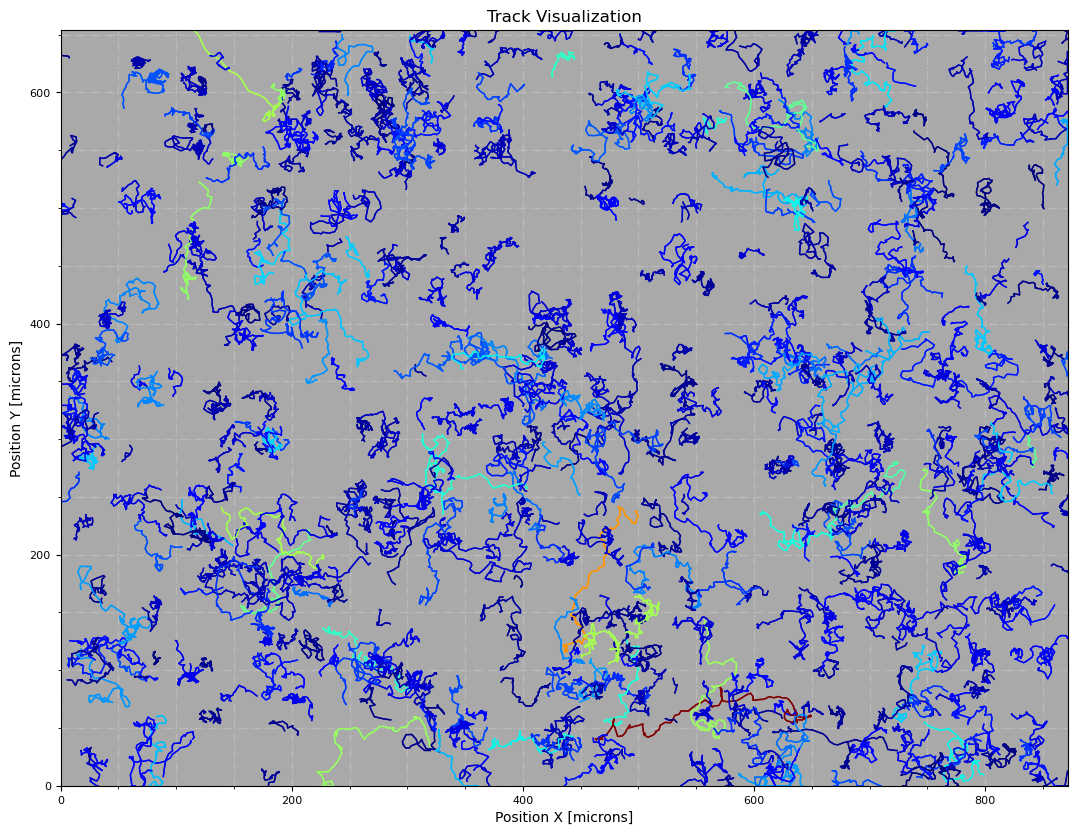

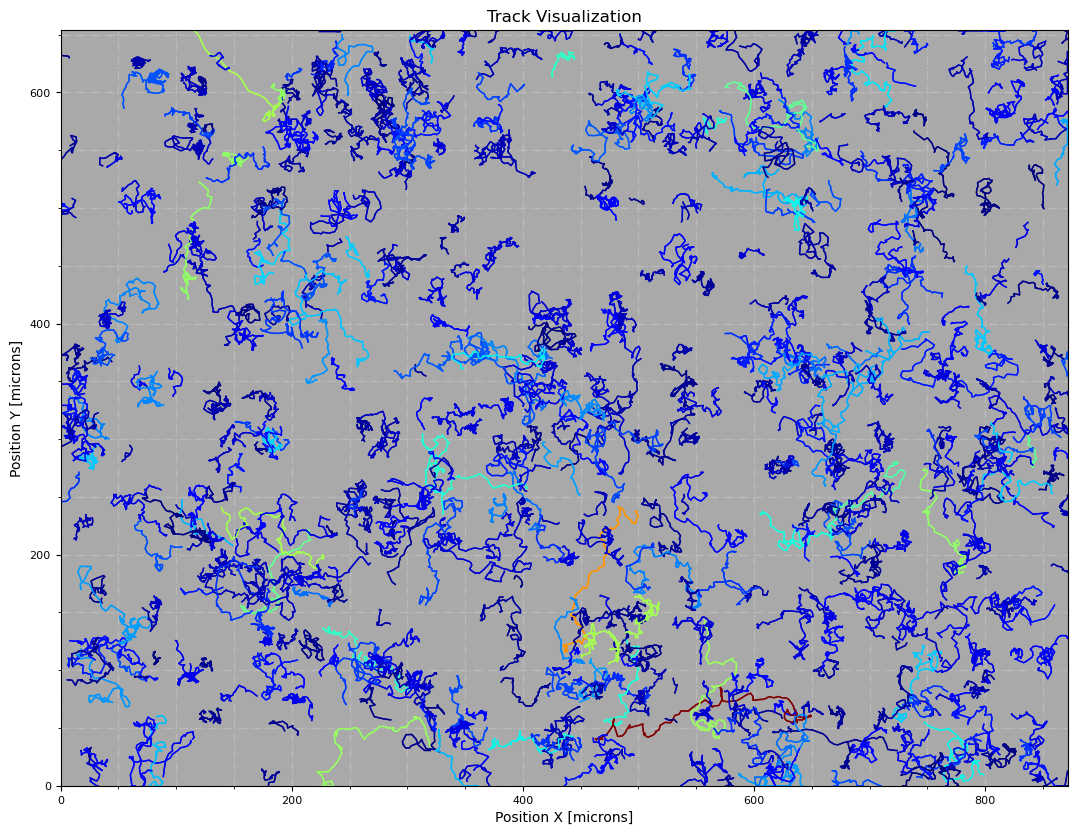

: 

: 

: 

In [ ]:
def visualize_tracks(df, df2, condition='all', replicate='all', c_mode='color1', grid=True, smoothing_index=0, lut_metric='NET_DISTANCE', lw=1, arrowsize=6):  # smoothened tracks visualization

    # try:
    #     condition = int(condition)
    #     replicate = int(replicate)
    # except ValueError or TypeError:
    #     pass

    if condition == None or replicate == None:
        pass
    else:
        try:
            condition = int(condition)
        except ValueError or TypeError:
            pass
        try:
            replicate = int(replicate)
        except ValueError or TypeError:
            pass

    if condition == 'all':
        df = df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])
    elif condition != 'all' and replicate == 'all':
        df = df[df['CONDITION'] == condition].sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])
    elif condition != 'all' and replicate != 'all':
        df = df[(df['CONDITION'] == condition) & (df['REPLICATE'] == replicate)].sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])


    # Using the  track_visuals function
    fig_visuals, ax_visuals, unique_tracks, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df2, c_mode, grid, lut_metric)

    # Plot the full tracks
    for condition in df['CONDITION'].drop_duplicates():
        condition_tracks = df[df['CONDITION'] == condition]
        for replicate in condition_tracks['REPLICATE'].drop_duplicates():
            replicate_tracks = condition_tracks[condition_tracks['REPLICATE'] == replicate]
            for track_id in replicate_tracks['TRACK_ID'].drop_duplicates():
                track_data = replicate_tracks[replicate_tracks['TRACK_ID'] == track_id]
                x = track_data['POSITION_X']
                y = track_data['POSITION_Y']

                # Apply smoothing to the track (if applicable)
                if smoothing_index == None:
                    x_smoothed = x
                    y_smoothed = y
                elif smoothing_index > 0:
                    x_smoothed = x.rolling(window=smoothing_index, min_periods=1).mean()
                    y_smoothed = y.rolling(window=smoothing_index, min_periods=1).mean()
                else:
                    x_smoothed = x
                    y_smoothed = y

                ax_visuals.plot(x_smoothed, y_smoothed, lw=lw, color=track_colors_visuals[f'{condition} {replicate} {track_id}'], label=f'Track {track_id}')
                
                # Get the original color from track_colors_visuals[track_id]
                arrow_color = mcolors.to_rgb(track_colors_visuals[f'{condition} {replicate} {track_id}'])

                if len(x_smoothed) > 1:
                    # Extract the mean direction from df2 for the current track
                    mean_direction_rad = df2[df2[['CONDITION', 'REPLICATE', 'TRACK_ID']] == [condition, replicate, track_id]]['MEAN_DIRECTION_RAD'].values[0]
                    
                    # Use trigonometry to calculate the direction (dx, dy) from the angle
                    dx = np.cos(mean_direction_rad)  # Change in x based on angle
                    dy = np.sin(mean_direction_rad)  # Change in y based on angle
                    
                    # Create an arrow to indicate direction
                    arrow = FancyArrowPatch(
                        posA=(x_smoothed.iloc[-2], y_smoothed.iloc[-2]),  # Start position (second-to-last point)
                        posB=(x_smoothed.iloc[-2] + dx, y_smoothed.iloc[-2] + dy),  # End position based on direction
                        arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                        color=arrow_color,  # Set the color of the arrow
                        mutation_scale=arrowsize,  # Scale the size of the arrow head (adjust this based on the plot scale)
                        linewidth=1.2,  # Line width for the arrow
                        zorder=30  # Ensure the arrow is drawn on top of the line
                    )

                    # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
                    plt.gca().add_patch(arrow)

    return plt.gcf()

# visualize_smoothened_tracks(Spot_stats, Track_stats, c_mode='greyscale')
visualize_tracks(Spot_stats, Track_stats, c_mode='color1')
# visualize_tracks(Spot_stats, Track_stats, c_mode='color2')
# visualize_tracks(Spot_stats, Track_stats, c_mode='color3')
# visualize_smoothened_tracks(Spot_stats, Track_stats, c_mode='color4')
# visualize_smoothened_tracks(Spot_stats, Track_stats, c_mode='color5')
# visualize_smoothened_tracks(Spot_stats, Track_stats, c_mode='color6')
# visualize_smoothened_tracks(Spot_stats, Track_stats, c_mode='color7')
# visualize_smoothened_tracks(Spot_stats, Track_stats, c_mode='color8')
# visualize_smoothened_tracks(Spot_stats, Track_stats, c_mode='color9')

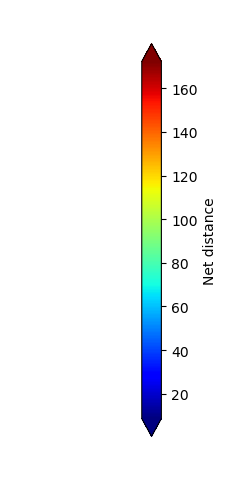

: 

: 

: 

In [ ]:
def tracks_lut_map(df2, c_mode='color1', lut_metric='NET_DISTANCE', metrics_dict=dict_Track_metrics):

    lut_norm_df = df2[['TRACK_ID', lut_metric]].drop_duplicates()

    # Normalize the NET_DISTANCE to a 0-1 range
    lut_min = lut_norm_df[lut_metric].min()
    lut_max = lut_norm_df[lut_metric].max()
    norm = plt.Normalize(vmin=lut_min, vmax=lut_max)


    if c_mode == 'greyscale':
        colormap = plt.cm.gist_yarg
    else:
        if c_mode == 'color1':
            colormap = plt.cm.jet
        elif c_mode == 'color2':
            colormap = plt.cm.brg
        elif c_mode == 'color3':
            colormap = plt.cm.hot
        elif c_mode == 'color4':
            colormap = plt.cm.gnuplot
        elif c_mode == 'color5':
            colormap = plt.cm.viridis
        elif c_mode == 'color6':
            colormap = plt.cm.rainbow
        elif c_mode == 'color7':
            colormap = plt.cm.turbo
        elif c_mode == 'color8':
            colormap = plt.cm.nipy_spectral
        elif c_mode == 'color9':
            colormap = plt.cm.gist_ncar
    
    # Add a colorbar to show the LUT map
    sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    sm.set_array([])
    # Create a separate figure for the LUT map (colorbar)
    fig_lut, ax_lut = plt.subplots(figsize=(2, 6))
    ax_lut.axis('off')
    cbar = fig_lut.colorbar(sm, ax=ax_lut, orientation='vertical', extend='both', shrink=0.85)
    cbar.set_label(metrics_dict[lut_metric], fontsize=10)

    plt.gcf()

tracks_lut_map(Track_stats, c_mode='color1', lut_metric='NET_DISTANCE', metrics_dict=dict_Track_metrics)

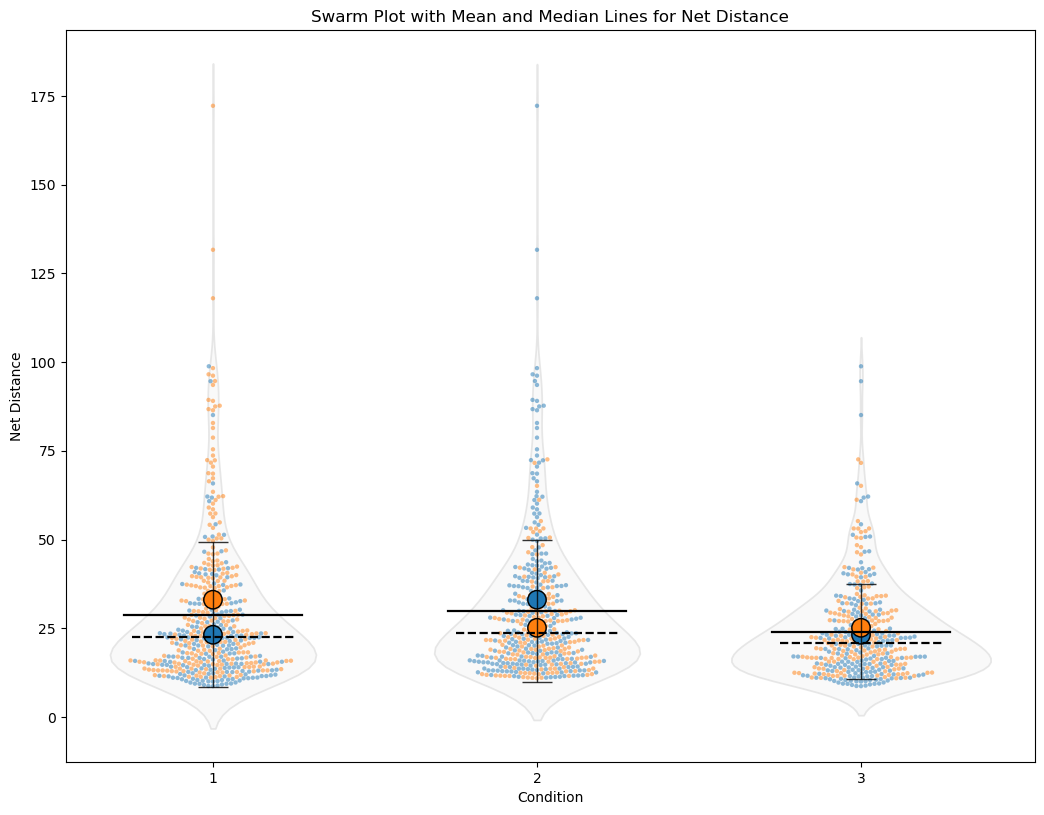

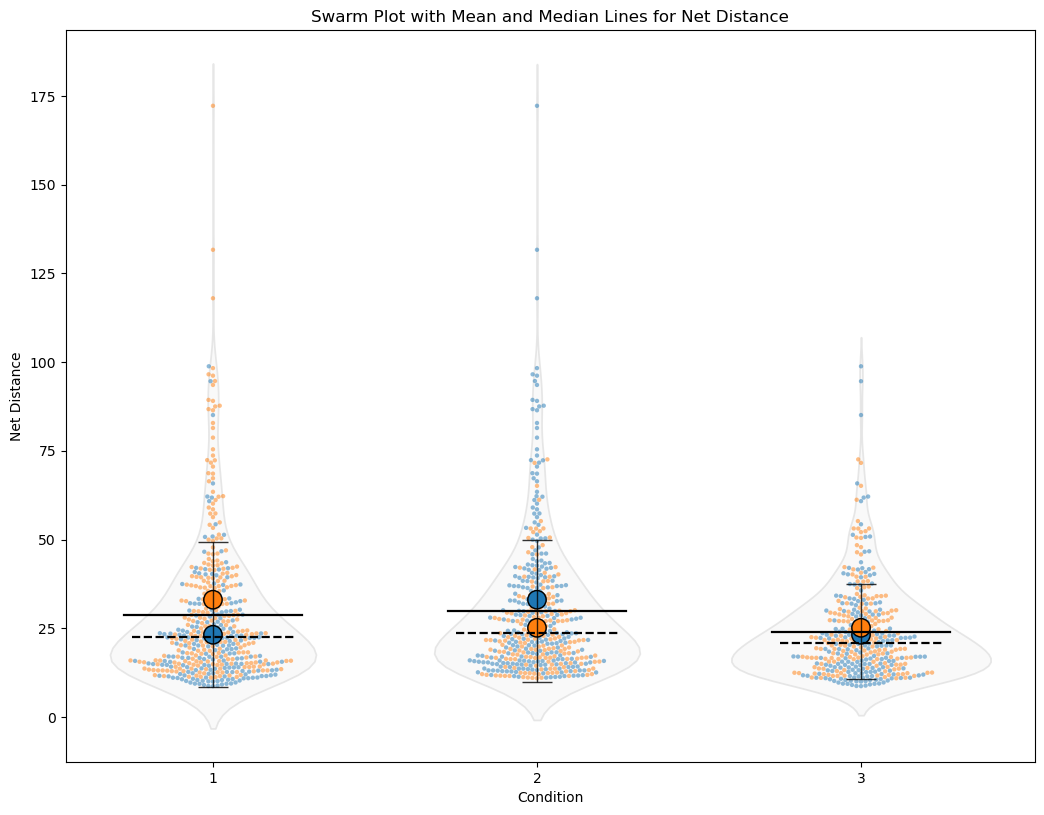

: 

: 

: 

In [ ]:
import matplotlib.lines as mlines

def my_data_swarm_plot_with_mean_median(df, metric, Metric, show_violin=True, show_swarm=True, show_mean=True, show_median=True, show_error_bars=True, show_legend=True, p_testing=False):
    # fig, ax = plt.subplots(figsize=(12.5, 9.5))
    
    # Set the figure size
    plt.figure(figsize=(12.5, 9.5))
    
    # Ensure CONDITION is treated as categorical
    df['CONDITION'] = df['CONDITION'].astype(str)

    swarm_size = 3.15
    swarm_alpha = 0.5

    violin_fill_color = 'whitesmoke'
    violin_edge_color = 'lightgrey'
    violin_alpha = 0.525

    mean_span = 0.275
    median_span = 0.25
    line_width = 1.6

    sns.despine()

    if show_swarm:
        sns.swarmplot(data=df, x='CONDITION', y=metric, hue='REPLICATE', palette='tab10', size=swarm_size, dodge=False, alpha=swarm_alpha, zorder=1, legend=False)
    else:
        pass

    replicate_means = df.groupby(['CONDITION', 'REPLICATE'])[metric].mean().reset_index()
    sns.scatterplot(data=replicate_means, x='CONDITION', y=metric, hue='REPLICATE', palette='tab10', edgecolor='black', s=175, zorder=3, legend=False)

    if show_violin:
        sns.violinplot(data=df, x='CONDITION', y=metric, color=violin_fill_color, edgecolor=violin_edge_color, inner=None, alpha=violin_alpha, zorder=0)
    else:
        pass

    # Calculate mean and median for each condition
    condition_stats = df.groupby('CONDITION')[metric].agg(['mean', 'median']).reset_index()

    # Plot mean and median lines for each condition using seaborn functions
    for i, row in condition_stats.iterrows():
        x_center = i # Adjust x-coordinate to start at the correct condition position
        if show_mean:
            sns.lineplot(x=[x_center - mean_span, x_center + mean_span], y=[row['mean'], row['mean']], color='black', linestyle='-', linewidth=line_width, zorder=4, label='Mean' if i == 0 else "")
        else:
            pass
        if show_median:
            sns.lineplot(x=[x_center - median_span, x_center + median_span], y=[row['median'], row['median']], color='black', linestyle='--', linewidth=line_width, zorder=4, label='Median' if i == 0 else "")
        else:
            pass

    # Calculate mean, median, and standard deviation for each condition
    condition_stats = df.groupby('CONDITION')[metric].agg(['mean', 'median', 'std']).reset_index()

    if show_error_bars:
        # Plot error bars representing mean ± standard deviation for each condition
        for i, row in condition_stats.iterrows():
            x_center = i
            plt.errorbar(x_center, row['mean'], yerr=row['std'], fmt='None', color='black', alpha=0.8,
                        linewidth=1, capsize=11, zorder=5, label='Mean ± SD' if i == 0 else "")
    else:
        pass
    
    if p_testing:
        # P-test
        # Perform pairwise p-tests
        conditions = df['CONDITION'].unique()
        pairs = list(combinations(conditions, 2))
        y_max = df[metric].max()
        y_offset = (y_max * 0.1)  # Offset for p-value annotations
        for i, (cond1, cond2) in enumerate(pairs):
            data1 = df[df['CONDITION'] == cond1][metric]
            data2 = df[df['CONDITION'] == cond2][metric]
            stat, p_value = mannwhitneyu(data1, data2)
            
            # Annotate the plot with the p-value
            x1, x2 = conditions.tolist().index(cond1), conditions.tolist().index(cond2)
            y = y_max + y_offset * (i + 1)
            plt.plot([x1, x1, x2, x2], [y+4.5, y + y_offset / 2.5, y + y_offset / 2.5, y+1.5], lw=1, color='black')
            plt.text((x1 + x2) / 2, y + y_offset / 2, f'p = {round(p_value, 3):.3f}', ha='center', va='bottom', fontsize=10, color='black')
        else:
            pass
        

    plt.title(f"Swarm Plot with Mean and Median Lines for {Metric}")
    plt.xlabel("Condition")
    plt.ylabel(Metric)
    # plt.legend(title='Legend', title_fontsize='12', fontsize='10', loc='upper right', bbox_to_anchor=(1.15, 1), frameon=True)
    # sns.replot

    # Create a custom legend entry for the replicates marker.
    # Here, we choose the first color of the palette ('tab10') as representative.
    replicate_handle = mlines.Line2D([], [], marker='o', color='w',
                                     markerfacecolor=sns.color_palette('tab10')[0],
                                     markeredgecolor='black', markersize=10,
                                     label='Replicates')

    # Get current handles and labels (from Mean, Median, and Error Bars)
    handles, labels = plt.gca().get_legend_handles_labels()
    # Append the custom replicates handle
    handles.insert(0, replicate_handle)
    labels.insert(0, 'Replicates')
    
    plt.legend(handles=handles, labels=labels,
               title='Legend', title_fontsize='12', fontsize='10',
               loc='upper right', bbox_to_anchor=(1.15, 1), frameon=True)
    
    if show_legend:
        pass
    else:
        plt.legend().remove()

    return plt.gcf()

# Example usage:
my_data_swarm_plot_with_mean_median(Track_stats, 'NET_DISTANCE', dict_Metrics['NET_DISTANCE'], show_legend=False)


In [ ]:
display(Time_stats)

CONDITION  REPLICATE  POSITION_T  MEAN_TRACK_LENGTH  MEAN_NET_DISTANCE  \
0            1          1           0           1.669142           0.000000   
1            1          1           1           3.136431           1.598114   
62           1          1           2           4.510307           2.237825   
73           1          1           3           6.095653           2.792770   
84           1          1           4           7.740306           3.567289   
..         ...        ...         ...                ...                ...   
802          3          2         145         152.197340          25.024467   
803          3          2         146         152.214509          25.427286   
804          3          2         147         147.966533          25.268052   
805          3          2         148         155.405975          25.691230   
806          3          2         149         156.332807          25.841205   

     MEAN_CONFINEMENT_RATIO  MEDIAN_TRACK_LENGTH  MEDIAN_NET_DISTANCE  \
0                  0.000000             1.227548             0.000000   
1                  0.497505             2.558185             1.195975   
62                 0.497946             4.019912             1.691618   
73                 0.451688             5.581751             2.150313   
84                 0.451062             7.307881             2.774990   
..                      ...                  ...                  ...   
802                0.207374           141.433515            21.475794   
803                0.211864           136.628465            22.073295   
804                0.215480           134.952668            21.591623   
805                0.207761           146.177975            21.950642   
806                0.209091           147.744351            22.286265   

     MEDIAN_CONFINEMENT_RATIO  STD_TRACK_LENGTH  ...  STD_DIRECTION_DEG  \
0                    0.000000          1.290032  ...           4.518994   
1                    0.490990          2.227792  ...           6.030287   
62                   0.491459          2.501496  ...           9.920203   
73                   0.434200          2.986913  ...           8.179087   
84                   0.435576          3.665700  ...           3.314832   
..                        ...               ...  ...                ...   
802                  0.159960         82.982252  ...           7.878280   
803                  0.162796         83.414517  ...           6.924984   
804                  0.173879         77.812002  ...           3.609390   
805                  0.161467         82.725899  ...           0.941549   
806                  0.161896         82.800268  ...           6.569155   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DIRECTION_RAD  \
0                     NaN            1.466292           0.078871   
1              113.878143            1.857028           0.105248   
62             128.035507            2.082383           0.173140   
73             107.873705            2.560765           0.142752   
84                    NaN            2.847309           0.057855   
..                    ...                 ...                ...   
802             84.392184            1.028339           0.137502   
803                   NaN           -2.998274           0.120864   
804                   NaN            2.943309           0.062996   
805                   NaN           -2.920335           0.016433   
806                   NaN           -2.236786           0.114653   

     MEDIAN_DIRECTION_RAD  MIN_SPEED  MAX_SPEED  MEAN_SPEED  STD_SPEED  \
0                     NaN   0.068300   5.924729    1.669142   1.290032   
1                1.987549   0.000000  12.284804    1.538317   1.587676   
62               2.234641   0.080884   5.434751    1.481832   1.105225   
73               1.882751   0.055810   4.794165    1.644989   1.115749   
84                    NaN   0.055505   5.068710    1.559348   1.187691   
..               

: 

: 

: 

In [ ]:
def get_q_cmap_list(elements, cmap):
    n = len(elements)
    if n == 0:
        return []
    cmap = plt.get_cmap(cmap)
    
    # Generate colors by sampling evenly from the colormap.
    colors = [mcolors.to_hex(cmap(i / n)) for i in range(n)]
    return colors

: 

: 

: 

In [ ]:
import subprocess
import sys
import altair as alt


cmaps_ = ['Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10']

def altair_poly_fit_chart(df, metric, Metric, condition='all', replicate='all', degree=[1], cmap=cmaps_[5], fill=False, point_size=75, outline_color='black', outline_width=1, opacity=0.6):
    
    if condition == None or replicate == None:
        pass
    else:
        try:
            condition = int(condition)
        except ValueError or TypeError:
            pass
        try:
            replicate = int(replicate)
        except ValueError or TypeError:
            pass

    if condition == 'all':
        df = df.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        element = 'CONDITION'
        shorthand = 'CONDITION:N'
        what = None
    elif condition != 'all' and replicate == 'all':
        df = df[df['CONDITION'] == condition].sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        shorthand = 'REPLICATE:N'
        element = 'REPLICATE'
        what = f'for condition {condition}'
    elif condition != 'all' and replicate != 'all':
        df = df[(df['CONDITION'] == condition) & (df['REPLICATE'] == replicate)].sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        shorthand = 'REPLICATE:N'
        element = 'REPLICATE'
        what = f'for condition {condition} and replicate {replicate}'   
    

    # Retrieve unique conditions and assign colors from the selected qualitative colormap.
    elements = df[element].unique().tolist()
    colors = get_q_cmap_list(elements, cmap)

    highlight = alt.selection_point(
        on="pointerover", fields=[element], nearest=True
        )
    
    # Create a base chart with the common encodings.
    base = alt.Chart(df).encode(
        x=alt.X('POSITION_T', title='Time position'),
        y=alt.Y(metric, title=Metric),
        color=alt.Color(shorthand, title='Condition', scale=alt.Scale(domain=elements, range=colors))
        )
    
    ignore = opacity/2 

    if fill:
        scatter = base.mark_circle(
            size=point_size,
            stroke=outline_color,
            strokeWidth=outline_width,
        ).encode(
            opacity=alt.when(~highlight).then(alt.value(ignore)).otherwise(alt.value(opacity)),
            tooltip=alt.value(None),
        ).add_params(
            highlight
        )
    else:
        # Scatter layer: displays the actual data points.
        scatter = base.mark_point(
            size=point_size, 
            filled=fill, 
            strokeWidth=outline_width,
        ).encode(
            opacity=alt.when(~highlight).then(alt.value(ignore)).otherwise(alt.value(opacity)),
            tooltip=alt.value(None),
        ).add_params(
            highlight
        )
        

    
    if degree[0] == 0:
        chart = alt.layer(scatter).properties(
            width=800,
            height=400,
            title=f'{Metric} with Polynomial Fits'
        ).configure_view(
            strokeWidth=1
        )
    else:
        # Build a list of polynomial fit layers, one for each specified degree.
        polynomial_fit = [
            base.transform_regression(
                "POSITION_T", metric,
                method="poly",
                order=order,
                groupby=[element],
                as_=["POSITION_T", str(order)]
            ).mark_line(
            ).transform_fold(
                [str(order)], as_=["degree", metric]
            ).encode(
                x=alt.X('POSITION_T', title='Time position'),
                y=alt.Y(metric, title=Metric),
                color=alt.Color(shorthand, title='Condition', scale=alt.Scale(domain=elements, range=colors)),
                size=alt.when(~highlight).then(alt.value(1.25)).otherwise(alt.value(3))
            )
            for order in degree
            ]
        
        # Layer the scatter points with all polynomial fits.
        chart = alt.layer(scatter, *polynomial_fit).properties(
            width=800,
            height=400,
            title=f'{Metric} with Polynomial Fits for {what}'
        ).configure_view(
            strokeWidth=1
        )
        
    return chart

# Example usage:
chart = altair_poly_fit_chart(Time_stats, 'MEAN_CONFINEMENT_RATIO', dict_Time_metrics['MEAN_CONFINEMENT_RATIO'], condition='all', degree=[1], cmap=cmaps_[1], fill=False, outline_color='', point_size=50, outline_width=4, opacity=0.4)
display(chart)
# chart = altair_poly_fit_chart(Time_stats, 'MEAN_CONFINEMENT_RATIO', dict_Time_metrics['MEAN_CONFINEMENT_RATIO'], degree=[2], cmap=cmaps_[1])
# display(chart)
# chart = altair_poly_fit_chart(Time_stats, 'MEAN_CONFINEMENT_RATIO', dict_Time_metrics['MEAN_CONFINEMENT_RATIO'], degree=[3], cmap=cmaps_[1])
# display(chart)
# chart = altair_poly_fit_chart(Time_stats, 'MEAN_CONFINEMENT_RATIO', dict_Time_metrics['MEAN_CONFINEMENT_RATIO'], degree=[5], cmap=cmaps_[1])
# display(chart)



# import fitz  # PyMuPDF

# # Open PDF
# doc = fitz.open(r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\code files\chart.pdf")

# # Convert each page to PNG
# for i, page in enumerate(doc):
#     pix = page.get_pixmap(dpi=300)
#     pix.save(f"chart.png")




alt.LayerChart(...)

: 

: 

: 

In [ ]:
print(Time_stats.columns)

Index(['CONDITION', 'REPLICATE', 'POSITION_T', 'MEAN_TRACK_LENGTH',
       'MEAN_NET_DISTANCE', 'MEAN_CONFINEMENT_RATIO', 'MEDIAN_TRACK_LENGTH',
       'MEDIAN_NET_DISTANCE', 'MEDIAN_CONFINEMENT_RATIO', 'STD_TRACK_LENGTH',
       'STD_NET_DISTANCE', 'STD_CONFINEMENT_RATIO', 'MIN_DISTANCE',
       'MAX_DISTANCE', 'MEAN_DISTANCE', 'STD_DISTANCE', 'MEDIAN_DISTANCE',
       'MEAN_DIRECTION_DEG', 'STD_DIRECTION_DEG', 'MEDIAN_DIRECTION_DEG',
       'MEAN_DIRECTION_RAD', 'STD_DIRECTION_RAD', 'MEDIAN_DIRECTION_RAD',
       'MIN_SPEED', 'MAX_SPEED', 'MEAN_SPEED', 'STD_SPEED', 'MEDIAN_SPEED'],
      dtype='object')


: 

: 

: 

In [ ]:

interpolations_ = [
    None,
    "basis",
    "basis-open",
    "basis-closed",
    "bundle",
    "cardinal",
    "cardinal-open",
    "cardinal-closed",
    "catmull-rom",
    "linear",
    "linear-closed",
    "monotone",
    "natural",
    "step",
    "step-before",
    "step-after"
    ]

extent_ = [
    'ci',  # Confidence interval
    'stdev',  # Standard deviation
    'stderr',  # Standard error
    'iqr',  # Interquartile range
    'min-max'  # Min-Max range
]


def altair_line_chart(df, metric, Metric, condition='all', replicate='all', cmap=cmaps_[5], interpolation=None, show_median=True):

    metric_mean = metric
    metric_median = metric.replace('MEAN', 'MEDIAN')


    if condition == None or replicate == None:
        pass
    else:
        try:
            condition = int(condition)
        except ValueError or TypeError:
            pass
        try:
            replicate = int(replicate)
        except ValueError or TypeError:
            pass

    if condition == 'all':
        df = df.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        element = 'CONDITION'
        shorthand = 'CONDITION:N'
        what = None
    elif condition != 'all' and replicate == 'all':
        df = df[df['CONDITION'] == condition].sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        shorthand = 'REPLICATE:N'
        element = 'REPLICATE'
        what = f'for condition {condition}'
    elif condition != 'all' and replicate != 'all':
        df = df[(df['CONDITION'] == condition) & (df['REPLICATE'] == replicate)].sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        shorthand = 'REPLICATE:N'
        element = 'REPLICATE'
        what = f'for condition {condition} and replicate {replicate}'   

    if show_median:
        median_opacity = 0.75
        Metric = Metric + ' and median'
    else:
        median_opacity = 0
            
    # Retrieve unique conditions and assign colors from the selected qualitative colormap.
    elements = df[element].unique().tolist()
    colors = get_q_cmap_list(elements, cmap)
    

    nearest = alt.selection_point(nearest=True, on="pointerover",
                              fields=['POSITION_T'], empty=False)    
    
    color_scale = alt.Scale(domain=elements, range=colors)

    mean_base = alt.Chart(df).encode(
        x=alt.X('POSITION_T', title='Time position'),
        y=alt.Y(metric_mean, title=None),
        color=alt.Color(shorthand, title='Condition', scale=color_scale),
        detail=alt.Detail('REPLICATE:N')
        )
    
    median_base = alt.Chart(df).encode(
        x=alt.X('POSITION_T', title='Time position'),
        y=alt.Y(metric_median, title='Median ' + Metric),
        color=alt.Color(shorthand, title='Condition', scale=color_scale),
        detail=alt.Detail('REPLICATE:N')
        )

    if interpolation is not None:
        mean_line = mean_base.mark_line(interpolate=interpolation)
        median_line = median_base.mark_line(interpolate=interpolation, strokeDash=[4, 3]).encode(
            opacity=alt.value(median_opacity)
            )
        text_median = 0
    else:
        mean_line = mean_base.mark_line()
        median_line = median_base.mark_line(strokeDash=[4, 3]).encode(
            opacity=alt.value(median_opacity)
            )


    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    mean_selectors = mean_base.mark_point().encode(
        opacity=alt.value(0),
        ).add_params(
        nearest
        )
    median_selectors = median_base.mark_point().encode(
        opacity=alt.value(0),
        ).add_params(
        nearest
        )
    
    when_near = alt.when(nearest)

    # Draw points on the line, and highlight based on selection
    mean_points = mean_base.mark_point().encode(
        opacity=when_near.then(alt.value(1)).otherwise(alt.value(0))
        )
    median_points = median_base.mark_point().encode(
        opacity=when_near.then(alt.value(1)).otherwise(alt.value(0))
        )

    # Draw text labels near the points, and highlight based on selection
    text_mean = mean_line.mark_text(align="left", dx=6, dy=-6).encode(
        color=alt.value('black'),	
        text=when_near.then(metric_mean).otherwise(alt.value(" "))
        )
    text_median = median_line.mark_text(align="left", dx=5, dy=-5).encode(
        color=alt.value('grey'),
        text=when_near.then(metric_median).otherwise(alt.value(" "))
        )

    # Draw a rule at the location of the selection
    rules = alt.Chart(df).mark_rule(color="gray").encode(
        x='POSITION_T',
        ).transform_filter(
        nearest
        )


    

    chart = alt.layer(
        mean_line, mean_points, text_mean, mean_selectors, rules, median_line, median_points, text_median, median_selectors
        ).properties(
        width=1200,
        height=500,
        title=f'{Metric} across time {what}'
        ).configure_view(
        strokeWidth=1
        ).interactive()

    return chart

# Example usage:
chart = altair_line_chart(Time_stats, 'MEAN_CONFINEMENT_RATIO', dict_Time_metrics['MEAN_CONFINEMENT_RATIO'], condition='all', cmap=cmaps_[1], interpolation=interpolations_[1], show_median=True)
display(chart)
chart.save('chart.html')
chart.save('chart.pdf')




import fitz  # PyMuPDF

# Open PDF
doc = fitz.open(r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\code files\chart.pdf")

# Convert each page to PNG
for i, page in enumerate(doc):
    pix = page.get_pixmap()
    pix.save(f"chart.png")


alt.LayerChart(...)

: 

: 

: 

In [ ]:
interpolations_ = [
    None,
    "basis",
    "basis-open",
    "basis-closed",
    "bundle",
    "cardinal",
    "cardinal-open",
    "cardinal-closed",
    "catmull-rom",
    "linear",
    "linear-closed",
    "monotone",
    "natural",
    "step",
    "step-before",
    "step-after"
    ]

extent_ = [
    'min-max',  # Min-Max range
    'origi',
    'ci',  # Confidence interval
    'stdev',  # Standard deviation
    'stderr',  # Standard error
    'iqr',  # Interquartile range
    ]

: 

: 

: 

In [ ]:
def altair_band_chart(df, metric, Metric, condition=1, replicate='all', cmap=cmaps_[5], interpolation=None, show_mean=True, extent=extent_[1]):

    metric_mean = metric
    metric_std = metric.replace('MEAN', 'STD')
    metric_min = metric.replace('MEAN', 'MIN')
    metric_max = metric.replace('MEAN', 'MAX')


    if replicate == 'all':
        df = df[df['CONDITION'] == condition].sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        df = df.groupby(['CONDITION', 'POSITION_T']).agg({metric_mean: 'mean', metric_std: 'std', metric_min: 'min', metric_max: 'max'}).reset_index()
        shorthand = 'CONDITION:N'
        element = 'CONDITION'
        element_ = 'Condition'
        what = f'for condition {condition}'
    elif replicate != 'all':
        df = df[(df['CONDITION'] == condition) & (df['REPLICATE'] == replicate)].sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        shorthand = 'REPLICATE:N'
        element = 'REPLICATE'
        element_ = 'Replicate'
        what = f'for condition {condition} and replicate {replicate}'

    if show_mean:
        mean_opacity = 1
    else:
        mean_opacity = 0

    df['lower'] = df[metric_mean] - df[metric_std]
    df['upper'] = df[metric_mean] + df[metric_std]

    # Retrieve unique conditions and assign colors from the selected qualitative colormap.
    elements = df[element].unique().tolist()
    colors = get_q_cmap_list(elements, cmap)
    color_scale=alt.Scale(domain=elements, range=colors)
    
    if extent == 'min-max':
        band = alt.Chart(df).encode(
            x=alt.X('POSITION_T', title='Time position'),
            y=alt.Y(metric_min),
            y2=alt.Y2(metric_max),
            color=alt.Color(shorthand, title=element_, scale=color_scale),
            tooltip=alt.value(None)
            )
        if interpolation is not None:
            band = band.mark_errorband(interpolate=interpolation)
        else:
            band = band.mark_errorband()

    elif extent == 'origi':
        band = alt.Chart(df).encode(
            x=alt.X('POSITION_T', title='Time position'),
            y=alt.Y('upper'),
            y2=alt.Y2('lower'),
            color=alt.Color(shorthand, title=element_, scale=color_scale),   
            opacity=alt.value(0.25),
            tooltip=alt.value(None)
        )
        if interpolation is not None:
            band = band.mark_errorband(interpolate=interpolation)
        else:
            band = band.mark_errorband()

    else:
        band = alt.Chart(df).mark_errorband(extent=extent).encode(
            x=alt.X('POSITION_T', title='Time position'),
            y=alt.Y('upper'),
            y2=alt.Y2('lower'),
            color=alt.Color(shorthand, title=element_, scale=color_scale),
            opacity=alt.value(0.25),
            tooltip=alt.value(None)
        )
        if interpolation is not None:
            band = band.mark_errorband(interpolate=interpolation)  
        else:
            band = band.mark_errorband()

    mean_base = alt.Chart(df).encode(
        x=alt.X('POSITION_T', title='Time position'),
        y=alt.Y(metric_mean, title=None),
        color=alt.Color(shorthand, title=element_, scale=color_scale),
        opacity=alt.value(mean_opacity),
        strokeWidth=alt.value(3),
        tooltip=alt.value(None)
        )

    if interpolation is not None:
        mean_line = mean_base.mark_line(interpolate=interpolation)
    else:
        mean_line = mean_base.mark_line()

    nearest = alt.selection_point(nearest=True, on="pointerover",
                              fields=['POSITION_T'], empty=False)    
    
    color_scale = alt.Scale(domain=elements, range=colors)

    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    mean_selectors = mean_base.mark_point().encode(
        opacity=alt.value(0),
        ).add_params(
        nearest
        )
    
    when_near = alt.when(nearest)

    mean_points = mean_base.mark_point().encode(
        opacity=when_near.then(alt.value(1)).otherwise(alt.value(0)),
        )    

    # Draw a rule at the location of the selection
    rules = alt.Chart(df).mark_rule(color="gray").encode(
        x='POSITION_T',
        ).transform_filter(
        nearest
        )

    # Calculate separate fields for each line of the tooltip.
    tooltip_data = alt.Chart(df).transform_calculate(
        tooltip_line1=f'"{element_}: " + datum.CONDITION',
        tooltip_line2=f'"Time point: " + datum.POSITION_T',
        tooltip_line3=f'"Mean: " + datum["{metric_mean}"]',
        tooltip_line4=f'"Std: " + datum["{metric_std}"]',
        tooltip_line5=f'"Min: " + datum["{metric_min}"]',
        tooltip_line6=f'"Max: " + datum["{metric_max}"]',
        )
    
    if condition == 'all':
        text_opacity = 0
    else:
        text_opacity = 1

    l = -75

    # Create text marks for each line.
    tooltip_line1_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=-30-l,  # adjust vertical offset as needed
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line1:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)

    tooltip_line2_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=-15-l,  # adjust vertical offset for the second line
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line2:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)

    tooltip_line3_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=0-l,  # adjust vertical offset for the third line
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line3:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)
    
    tooltip_line4_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=15-l,  # adjust vertical offset for the fourth line
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line4:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)
    
    tooltip_line5_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=30-l,  # adjust vertical offset for the fifth line
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line5:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)
    
    tooltip_line6_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=45-l,  # adjust vertical offset for the sixth line
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line6:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)

    # Layer the tooltip text marks with your other layers.
    chart = alt.layer(
        band, mean_line, mean_points, mean_selectors, rules,
        tooltip_line1_mark, tooltip_line2_mark, tooltip_line3_mark, tooltip_line4_mark, tooltip_line5_mark, tooltip_line6_mark
        ).properties(
        width=1200,
        height=300,
        title=f'{Metric} with its standard deviation across time {what}'
        ).interactive()

    return chart

chart = altair_band_chart(Time_stats, 'MEAN_SPEED', dict_Time_metrics['MEAN_SPEED'], condition=1, cmap=cmaps_[5], interpolation=interpolations_[2], show_mean=True, extent=extent_[1])
display(chart)

alt.LayerChart(...)

: 

: 

: 

In [ ]:
# Sort by FRAME or POSITION_T (in case order isn't guaranteed)
Spot_stats.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'], inplace=True)

# Group by TRACK_ID and get starting position
start_positions = Spot_stats.groupby('CONDITION', 'REPLICATE', 'TRACK_ID')[['POSITION_X', 'POSITION_Y']].first().rename(
    columns={'POSITION_X': 'X0', 'POSITION_Y': 'Y0'}
)

# Merge start positions back into the main dataframe
df = Spot_stats.merge(start_positions, on='TRACK_ID')

# Compute normalized positions
df['NORM_X'] = df['POSITION_X'] - df['X0']
df['NORM_Y'] = df['POSITION_Y'] - df['Y0']

df.to_csv('normalized_positions.csv', index=False)

ValueError: No axis named REPLICATE for object type DataFrame

: 

: 

: 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Function execution &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

## Thresholding &#x1F3D7;
---
[Function with defined thresholds extracting various dataframes]

&#x1F6A7; *under construction* &#x1F6A7;

In [ ]:
def split_dataframe_by_percentiles(df, column_name):
    # Get to know the data frames name
    df_name = [name for name, value in globals().items() if value is df][0]

    # Dictionary to store each DataFrame filtered by percentiles
    dataframes_by_percentile = {}

    # Calculate percentiles and filter the DataFrame for each
    for percentile in range(10, 100, 10):
        threshold_value = df[column_name].quantile(percentile / 100)
        filtered_df = df[df[column_name] > threshold_value]

        # Save the DataFrame
        filename = f'{df_name}_with_{column_name}_thresholded_at_{percentile}th_percentile.csv'
        filtered_df.to_csv(op.join(save_path, filename), index=False)

        # Store in dictionary (optional)
        dataframes_by_percentile[f'threshold_at_{percentile}th_percentile'] = filtered_df

    # Accessing a specific DataFrame for, say, the 30th percentile
    df_thresholded_at_10th_percentile = dataframes_by_percentile['threshold_at_10th_percentile'] # 10th
    df_thresholded_at_20th_percentile = dataframes_by_percentile['threshold_at_20th_percentile'] # 20th
    df_thresholded_at_30th_percentile = dataframes_by_percentile['threshold_at_30th_percentile'] # 30th
    df_thresholded_at_40th_percentile = dataframes_by_percentile['threshold_at_40th_percentile'] # 40th
    df_thresholded_at_50th_percentile = dataframes_by_percentile['threshold_at_50th_percentile'] # 50th
    df_thresholded_at_60th_percentile = dataframes_by_percentile['threshold_at_60th_percentile'] # 60th
    df_thresholded_at_70th_percentile = dataframes_by_percentile['threshold_at_70th_percentile'] # 70th
    df_thresholded_at_80th_percentile = dataframes_by_percentile['threshold_at_80th_percentile'] # 80th
    df_thresholded_at_90th_percentile = dataframes_by_percentile['threshold_at_90th_percentile'] # 90th


    return df_thresholded_at_10th_percentile, df_thresholded_at_20th_percentile, df_thresholded_at_30th_percentile, df_thresholded_at_40th_percentile, df_thresholded_at_50th_percentile, df_thresholded_at_60th_percentile, df_thresholded_at_70th_percentile, df_thresholded_at_80th_percentile, df_thresholded_at_90th_percentile
Track_stats_thresholded_at_10th_percentile, Track_stats_thresholded_at_20th_percentile, Track_stats_thresholded_at_30th_percentile, Track_stats_thresholded_at_40th_percentile, Track_stats_thresholded_at_50th_percentile, Track_stats_thresholded_at_60th_percentile, Track_stats_thresholded_at_70th_percentile, Track_stats_thresholded_at_80th_percentile, Track_stats_thresholded_at_90th_percentile = split_dataframe_by_percentiles(Track_stats, 'NET_DISTANCE')

# You should try: split_dataframe_by_percentiles(df, column_name); column_name = 'NET_DISTANCE', 'TRACK_LENGTH', 'CONFINEMENT_RATIO', 'SPEED_MEDIAN AND OR MEAN, ETC 


NameError: name 'save_path' is not defined

: 

: 

: 

## Visualizers, Plots, Histograms &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

---
### Defining the optic parameters
Defining the pixel length, imaging winfow parameters and aspect ratio based on the microscope:

In [ ]:
# Definition of micron length per pixel
microns_per_pixel = 0.7381885238402274 # for 10x lens

# Define the desired dimensions in microns
x_min, x_max = 0, (1600 * microns_per_pixel)
y_min, y_max = 0, (1200 * microns_per_pixel)
x_axe_remainder = x_max-1150
x_add = 50 - x_axe_remainder
y_ax_remainder = y_max-850
x_substract = (x_max - y_max) + (y_ax_remainder - 50)

# Calculate the aspect ratio
aspect_ratio = x_max / y_max

: 

: 

: 

In [ ]:
title_size = 18
label_size = 11
figtext_size = 9
compass_annotations_size = 15
figtext_color = 'grey'

: 

: 

: 

---
### Defining settings and the parametres for track visualization &#x1F3D7;

Defining the settings and parametres for visualization separately, so that they need not be defined over again in each of the different track visualizations

&#x1F6A7; *under construction* &#x1F6A7; 

In [ ]:
def track_visuals(df, df2):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].unique()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = df_filtered['POSITION_X'].min(), df_filtered['POSITION_X'].max()
    y_min, y_max = df_filtered['POSITION_Y'].min(), df_filtered['POSITION_Y'].max()
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('dimgrey')
    ax.grid(True, which='both', axis='both', color='grey', linewidth=1)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

: 

: 

: 

---
### Visualizing the tracks &#x1F3D7;

*Overview of the tracks:*

&#x1F6A7; *under construction* &#x1F6A7; 

In [ ]:
def track_visuals(df, df2):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].unique()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = df_filtered['POSITION_X'].min(), df_filtered['POSITION_X'].max()
    y_min, y_max = df_filtered['POSITION_Y'].min(), df_filtered['POSITION_Y'].max()
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('dimgrey')

    # Manually draw rotated gridlines
    color = 'grey'     # Gridline color
    alpha = 0.2        # Gridline transparency
    lw = 0.6           # Gridline width
    grid_spacing = 50  # Adjust the spacing of gridlines
    angle1 = 45        # Rotation angle in degrees
    angle2 = -45       # Rotation angle in degrees
    z_order = 0.5      # Gridline z-order

    for x in np.arange(x_min, x_max, grid_spacing):
        for y in np.arange(y_min, y_max, grid_spacing):
            # Compute the rotated line endpoints
            x_lines_a = [x, x + (y_max - y_min) * np.tan(np.radians(angle1))]
            y_lines_a = [y, y + (x_max - x_min) * np.tan(np.radians(angle1))]
            x_lines_b = [x, x + (y_max - y_min) * np.tan(np.radians(angle2))]
            y_lines_b = [y, y + (x_max - x_min) * np.tan(np.radians(angle2))]
            ax.plot(x_lines_a, [y_min, y_max], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(y_lines_a, [(x_max+x_add), (x_min+x_add)], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(x_lines_b, [y_min, y_max], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(y_lines_b, [(x_max - x_substract), (x_min - x_substract)], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)

    # Standard gridlines (optional)
    ax.grid(False)  # Turn off default gridlines


    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

: 

: 

: 

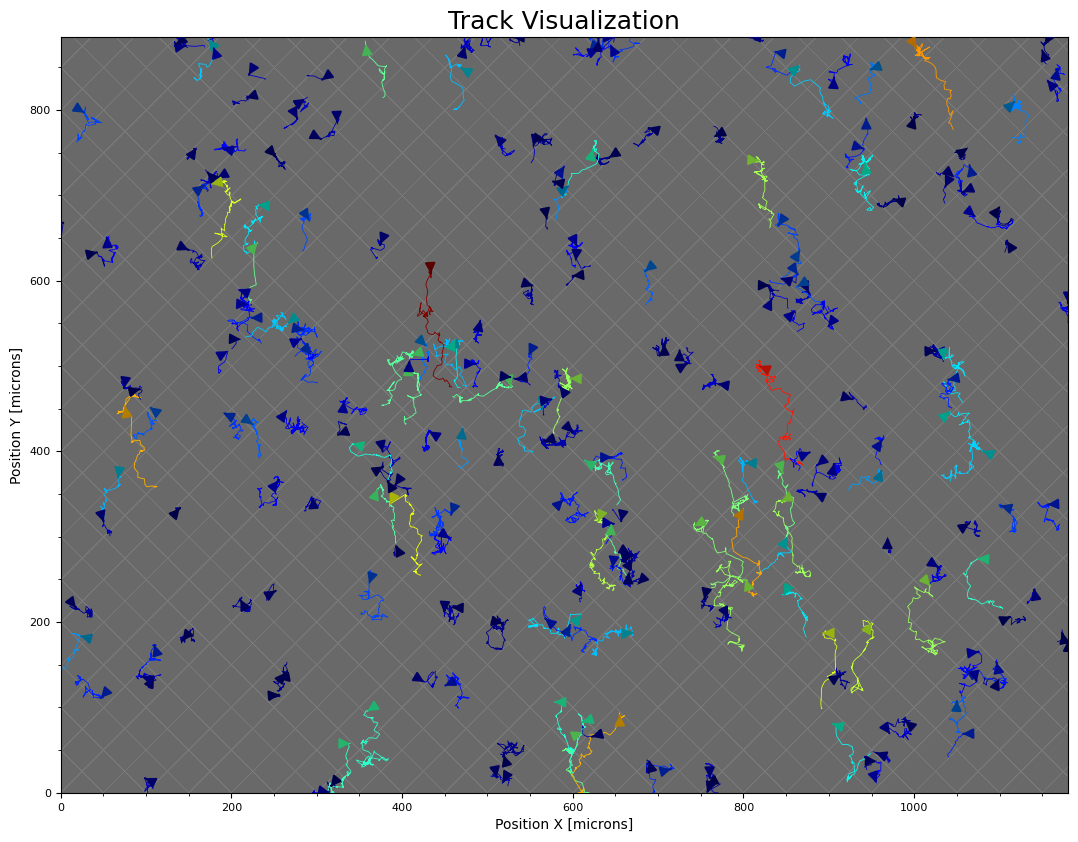

: 

: 

: 

In [ ]:
def visualize_full_tracks(df, df2, threshold, lw=1):  #Trakcs visualisation

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the  track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        ax_visuals.plot(x, y, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')
        
        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment
    

        if len(x) > 1:
            # Add arrow to indicate direction
            dx = x.diff().iloc[-1]
            dy = y.diff().iloc[-1]
            if dx != 0 or dy != 0:
                # Create an arrow instead of a circle
                arrow = FancyArrowPatch(
                    posA=(x.iloc[-2], y.iloc[-2]),  # Start position (second-to-last point)
                    posB=(x.iloc[-1], y.iloc[-1]),  # End position (last point)
                    arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                    color=color,  # Set the color of the arrow
                    mutation_scale=15,  # Scale the size of the arrow head (adjust this based on the plot scale)
                    linewidth=1.5,  # Line width for the arrow
                    zorder=10  # Ensure the arrow is drawn on top of the line
                )

                # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
                plt.gca().add_patch(arrow)

    plt.savefig((op.join(save_path, f'01a_Full_tracks_snapshot{threshold}.png')), dpi=300)
    # plt.show()
visualize_full_tracks(butter_df, Track_stats, None, lw=0.6)
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_20th_percentile, 'thresholded_at_20th_percentile') # 20th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_40th_percentile, 'thresholded_at_40th_percentile') # 40th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_60th_percentile, 'thresholded_at_60th_percentile') # 60th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_80th_percentile, 'thresholded_at_80th_percentile') # 80th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_90th_percentile, 'thresholded_at_90th_percentile') # 90th

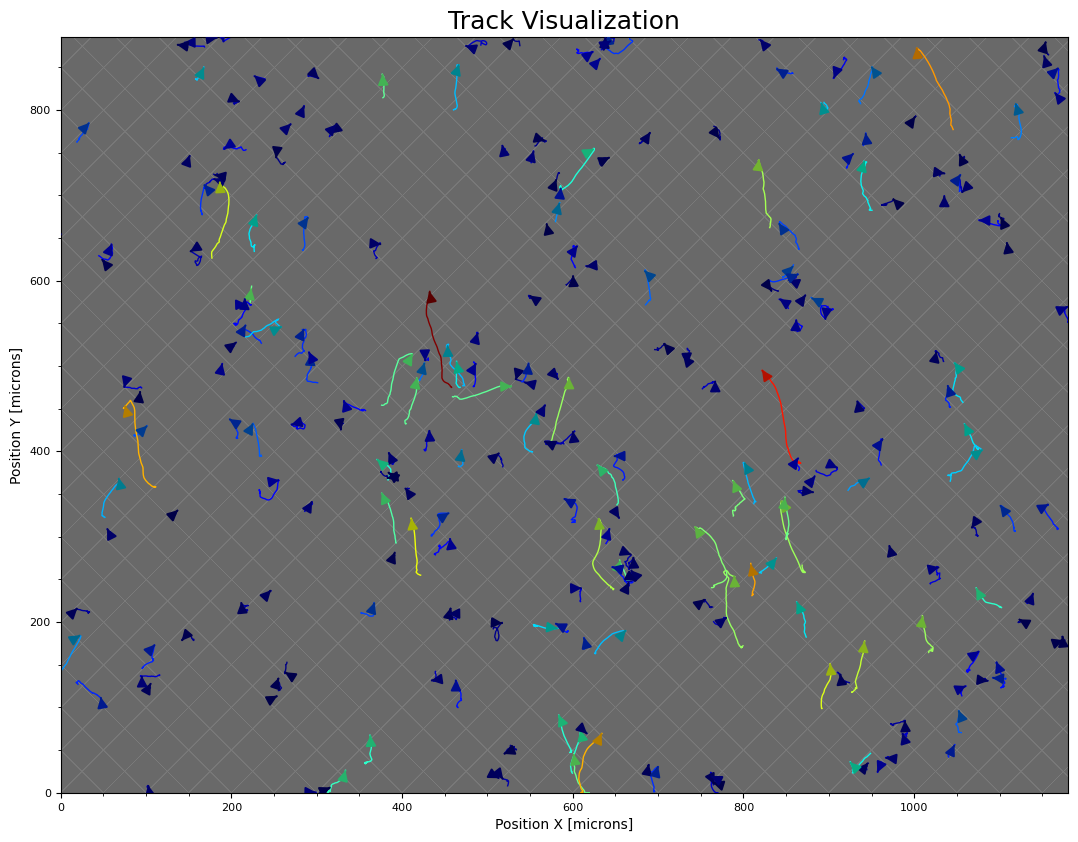

: 

: 

: 

In [ ]:
def visualize_smoothed_tracks(df, df2, threshold, smoothing_type=None, smoothing_index=10, lw=1):  # Tracks visualization

    # Recognizing the presence of a threshold
    if threshold is None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        
        # Apply smoothing to the track (if applicable)
        if smoothing_type == 'moving_average':
            x_smoothed = x.rolling(window=smoothing_index, min_periods=1).mean()
            y_smoothed = y.rolling(window=smoothing_index, min_periods=1).mean()
        else:
            x_smoothed = x
            y_smoothed = y

        ax_visuals.plot(x_smoothed, y_smoothed, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')

        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment


        if len(x_smoothed) > 1:
            # Extract the mean direction from df2 for the current track
            mean_direction_rad = df2[df2['TRACK_ID'] == track_id]['MEAN_DIRECTION_RAD'].values[0]
            
            # Use trigonometry to calculate the direction (dx, dy) from the angle
            dx = np.cos(mean_direction_rad)  # Change in x based on angle
            dy = np.sin(mean_direction_rad)  # Change in y based on angle
            
            # Create an arrow to indicate direction
            arrow = FancyArrowPatch(
                posA=(x_smoothed.iloc[-2], y_smoothed.iloc[-2]),  # Start position (second-to-last point)
                posB=(x_smoothed.iloc[-2] + dx, y_smoothed.iloc[-2] + dy),  # End position based on direction
                arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                color=color,  # Set the color of the arrow
                mutation_scale=15,  # Scale the size of the arrow head (adjust this based on the plot scale)
                linewidth=1.5,  # Line width for the arrow
                zorder=30  # Ensure the arrow is drawn on top of the line
            )

            # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
            plt.gca().add_patch(arrow)

    plt.savefig((op.join(save_path, f'01a_Full_tracks_snapshot{threshold}.png')), dpi=300)
    # plt.show()

# Example usage
visualize_smoothed_tracks(butter_df, Track_stats, None, smoothing_type='moving_average', smoothing_index=50, lw=1)


---
### Histograms describing cell motility &#x1F3D7;

*Histogram plotting all cells in the dataset and its migrated distance together with the time window in which it has been imaged:*

&#x1F6A7; *under construction* &#x1F6A7; 

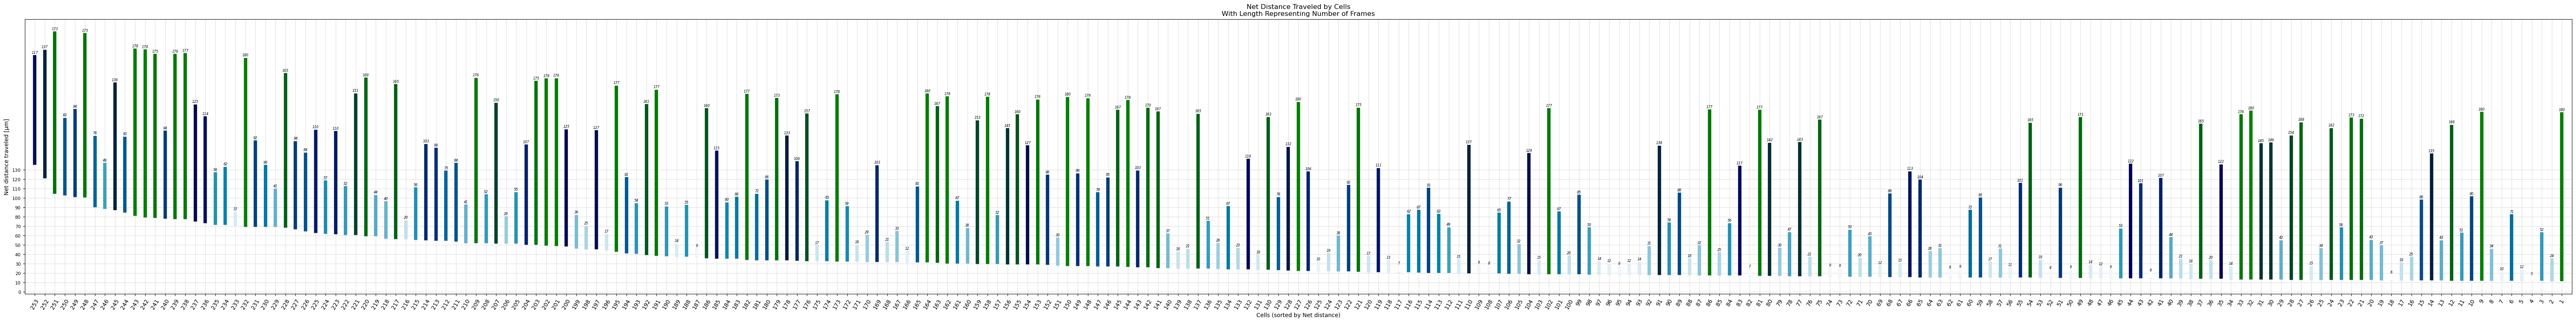

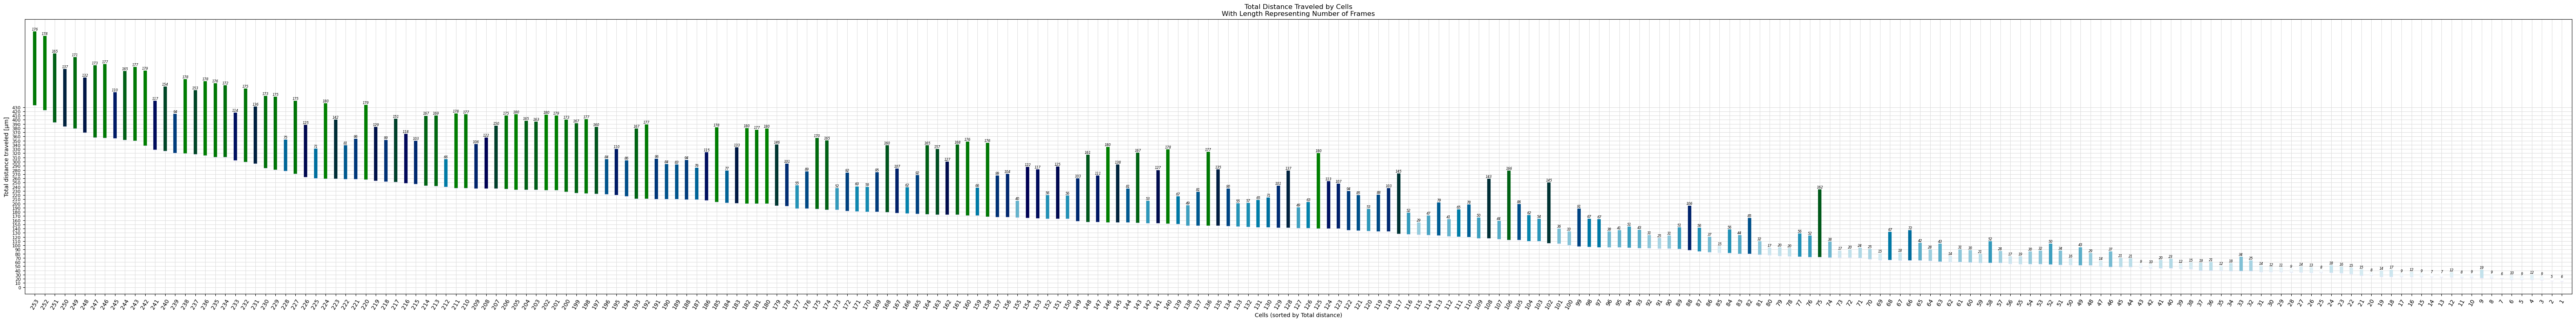

: 

: 

: 

In [ ]:

def histogram_cells_distance(df, metric, str):
    
    # Sort the DataFrame by 'TRACK_LENGTH' in ascending order
    df_sorted = df.sort_values(by=metric)

    norm = mcolors.Normalize(vmin=df_sorted["NUM_FRAMES"].min(), vmax=df_sorted["NUM_FRAMES"].max())
    cmap = plt.colormaps["ocean_r"]

    # Create new artificial IDs for sorting purposes (1 for lowest distance, N for highest)
    df_sorted["Artificial_ID"] = range(1, len(df_sorted) + 1)

    x_span = PlotParams.x_span(df_sorted)

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(x_span, 8))
    fig.set_tight_layout(True)
    width = 6

    # Loop through each row to plot each cell's data
    for idx, row in df_sorted.iterrows():
        artificial_id = row["Artificial_ID"]
        track_length = row[metric]
        num_frames = row["NUM_FRAMES"]

        # Get the color based on the number of frames using the viridis colormap
        line_color = cmap(norm(num_frames))

        # Plot the "chimney" or vertical line
        ax.vlines(
            x=artificial_id,  # X position for the cell
            ymin=track_length,  # Starting point of the line (y position)
            ymax=track_length + num_frames,  # End point based on number of frames (height)
            color=line_color,
            linewidth=width,
            )

        plt.plot(artificial_id, track_length, '_', zorder=5, color="lavender")

        # Add the mean number of frames as text above each chimney
        ax.text(
        artificial_id,  # X position (same as the chimney)
        track_length + num_frames + 1,  # Y position (slightly above the chimney)
        f"{round(num_frames)}",  # The text to display (formatted mean)
        ha='center',  # Horizontal alignment center
        va='bottom',  # Vertical alignment bottom
        fontsize=6,  # Adjust font size if necessary
        color='black',  # Color of the text
        style='italic'  # Italicize the text
        )

        x = int(row['Artificial_ID'])

        plt.xticks(range(x), rotation=90) # add loads of ticks
        plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
        plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)


    max_y = df_sorted[metric].max()
    num_x_values = df_sorted[metric].count()

    # Adjust the plot aesthetics
    plt.tick_params(axis='x', rotation=60)
    plt.tick_params(axis='y', labelsize=8)
    plt.xticks(range(num_x_values)) # add loads of ticks
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

    # Set ticks, labels and title
    ax.set_xticks(range(1, num_x_values + 1))
    ax.set_yticks(np.arange(0, max_y + 1, 10))
    ax.set_xlabel(f"Cells (sorted by {str} distance)")
    ax.set_ylabel(f"{str} distance traveled [μm]")
    ax.set_title(f"{str} Distance Traveled by Cells\nWith Length Representing Number of Frames")

    # Invert x-axis so the highest distance is on the left
    plt.gca().invert_xaxis()

    ax.set_xlim(right=0, left=num_x_values+1)  # Adjust the left limit as needed

    # Show the plot
    plt.savefig(op.join(save_path, f"02f_Histogram_{str}_distance_traveled_per_cell.png"))
    plt.show()
histogram_cells_distance(Track_stats, 'NET_DISTANCE', 'Net')
histogram_cells_distance(Track_stats, 'TRACK_LENGTH', 'Total')

---
*Histogram plotting percentile groups in the cell dataset - migrated distance together with the time window in which it has been imaged:*

&#x1F6A7; *under construction* &#x1F6A7; 

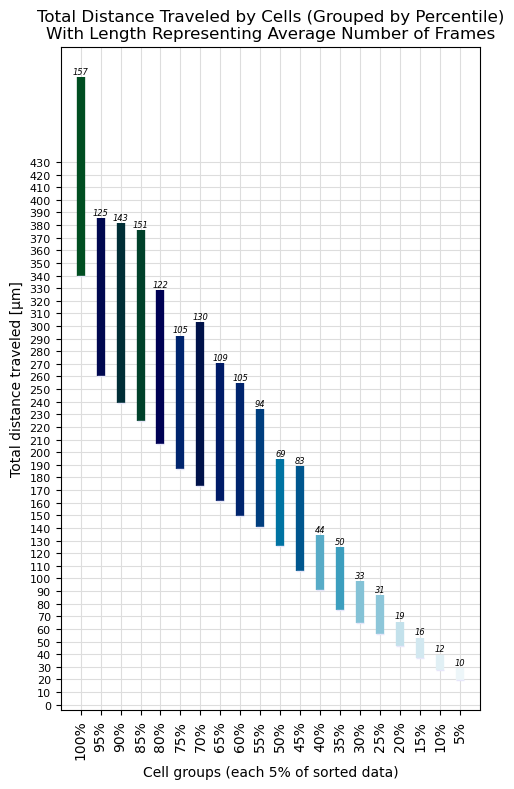

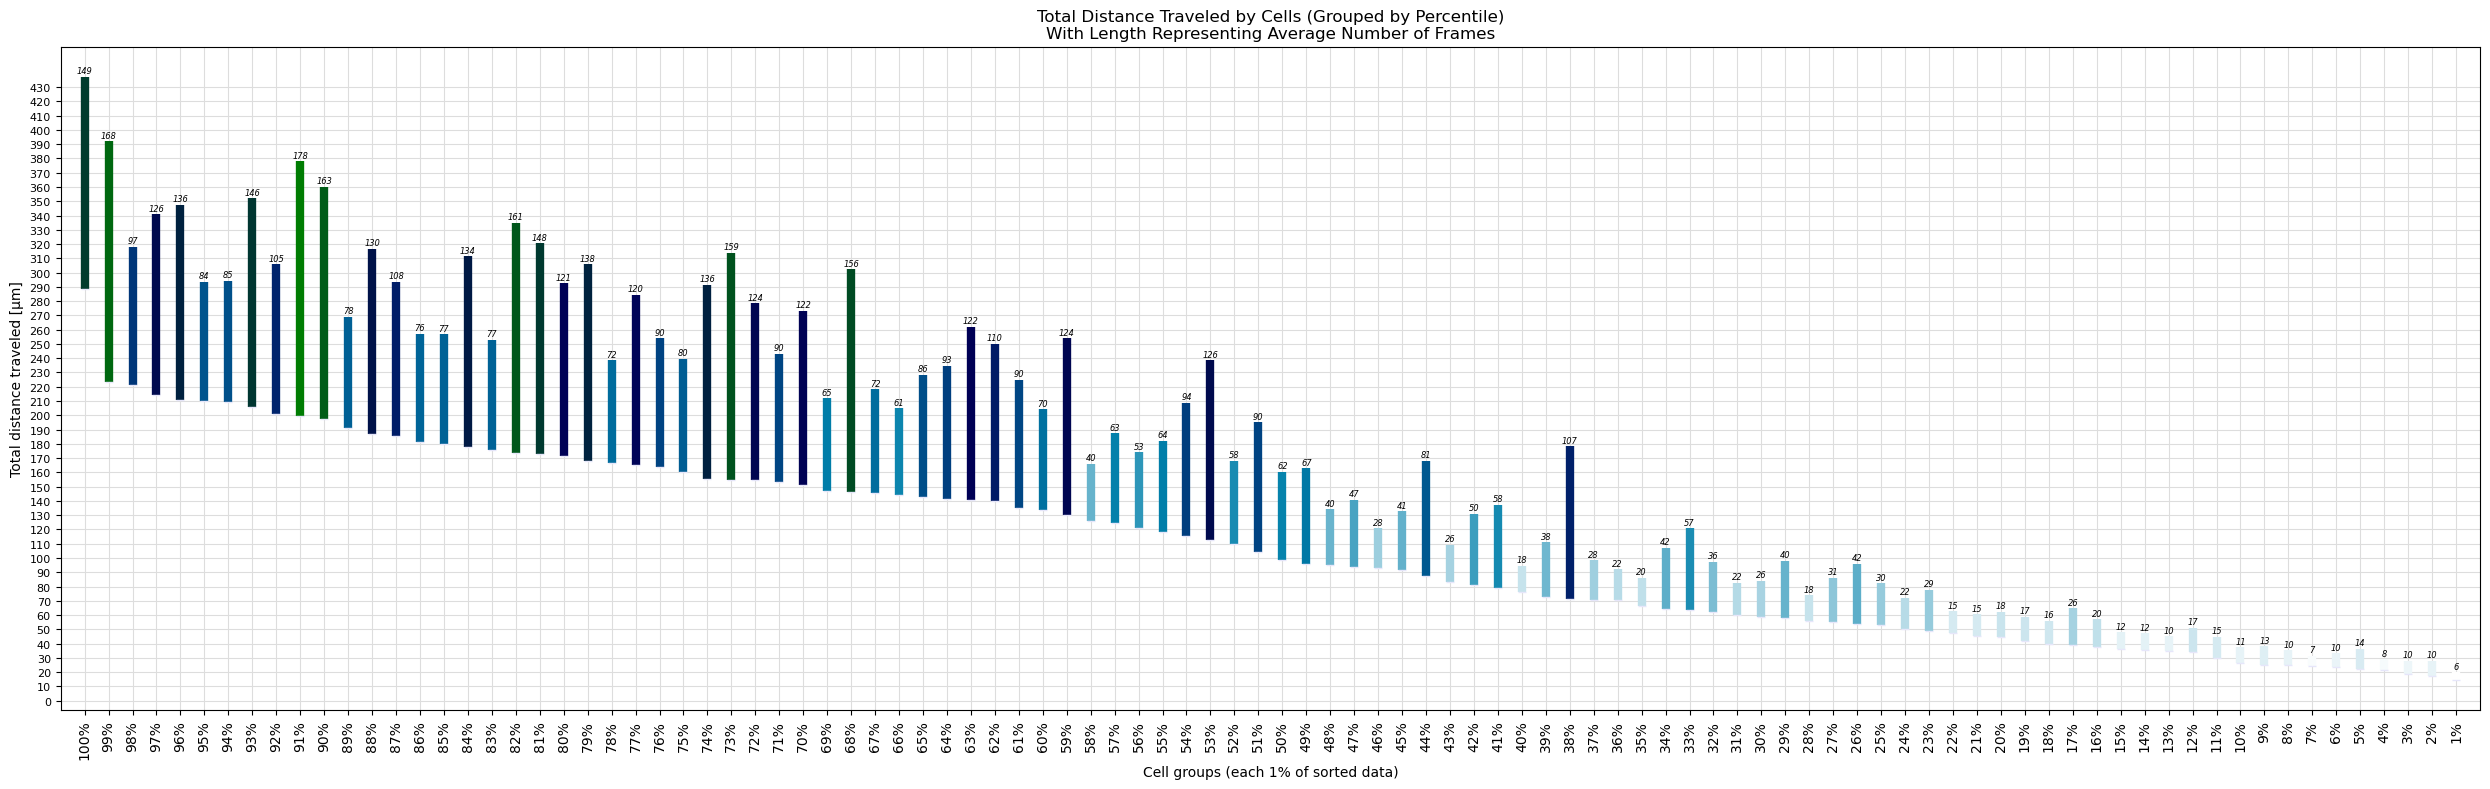

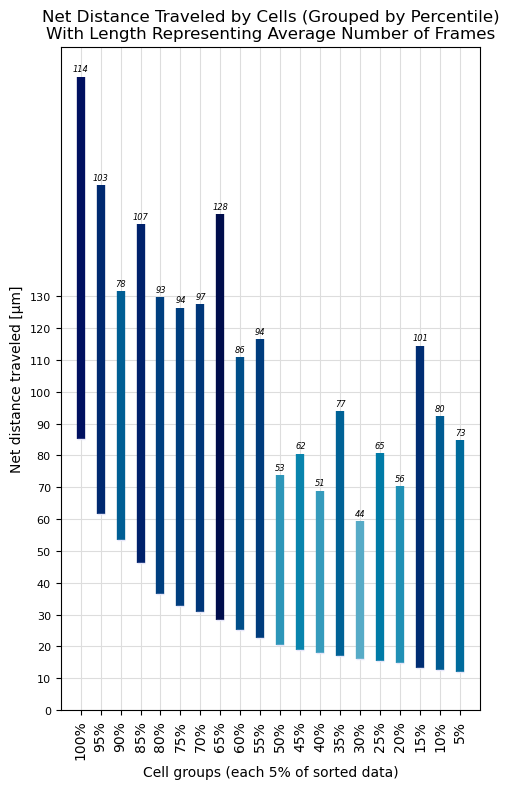

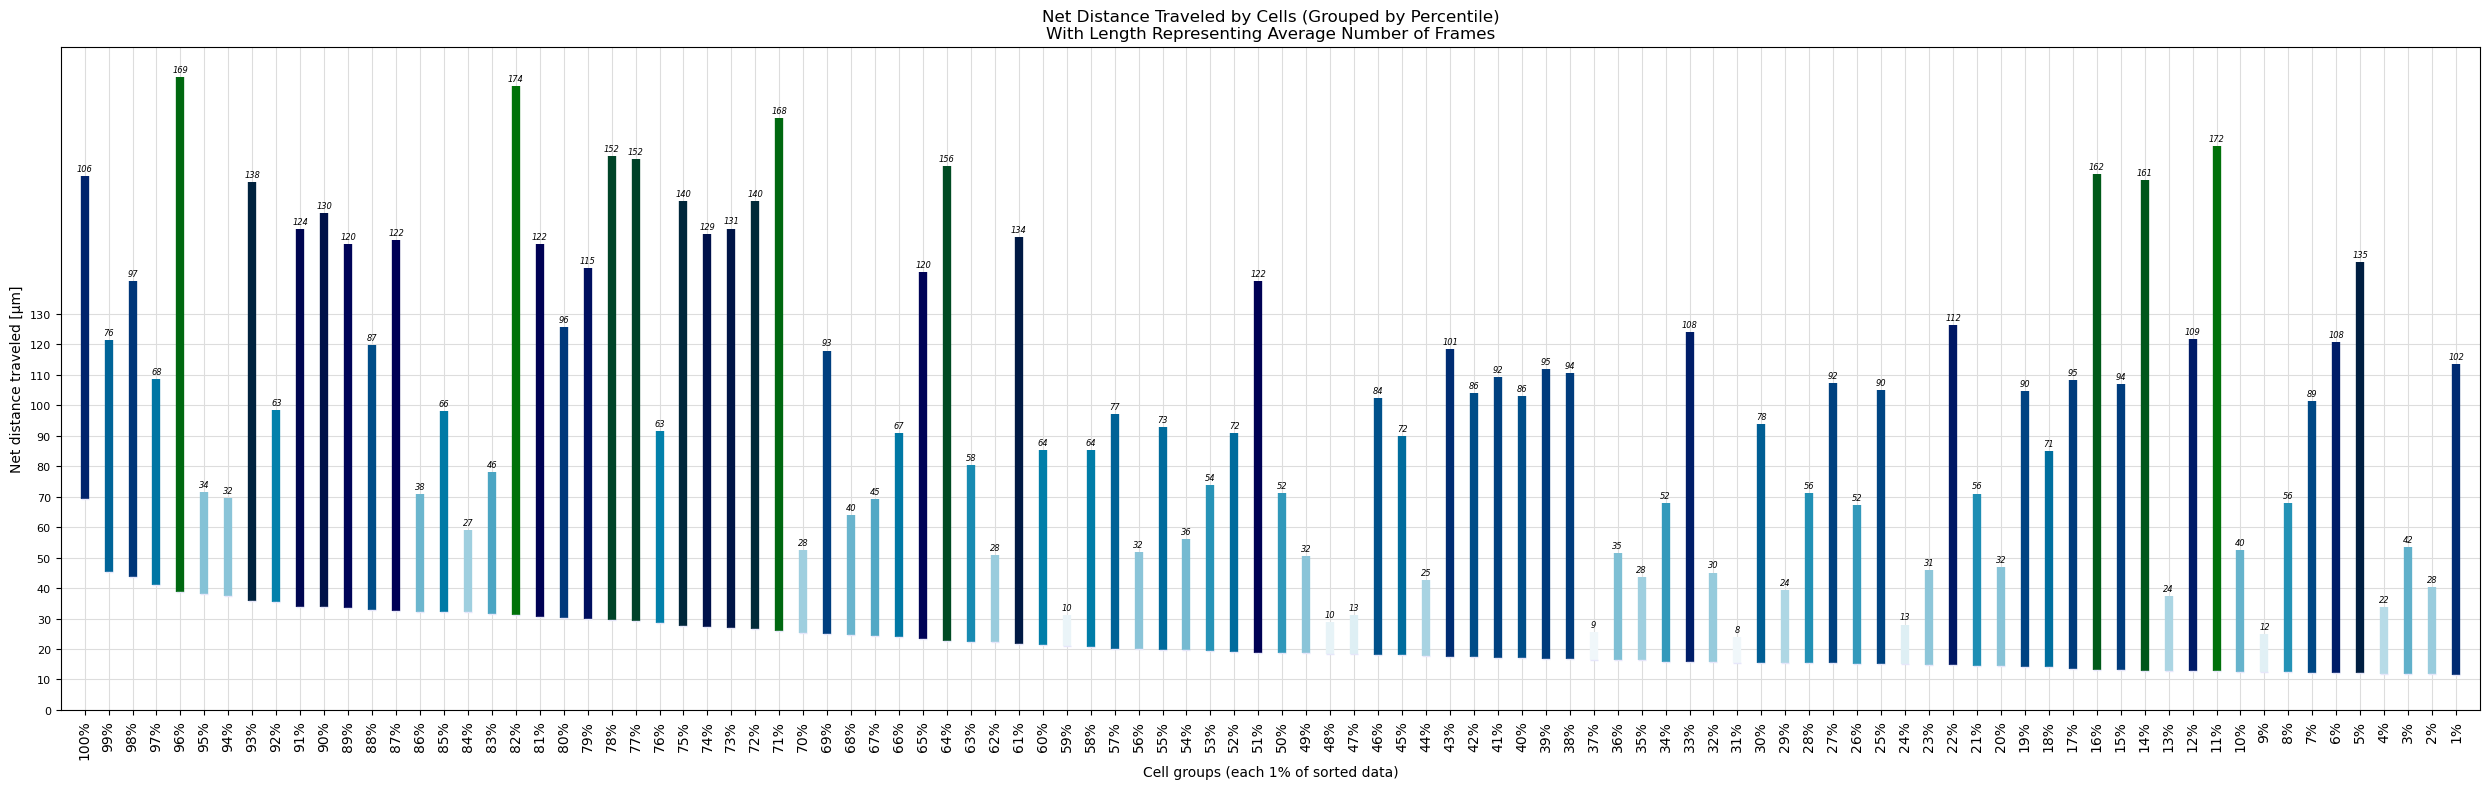

: 

: 

: 

In [ ]:
def histogram_nth_percentile_distance(df, metric, num_groups, percentiles, str, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Sort the DataFrame by 'NET_DISTANCE' in ascending order
    df_sorted = df.sort_values(by=metric)

    # Number of groups (chimneys) and size of each group (5% each)
    group_size = len(df_sorted) // num_groups

    x_span = num_groups * 0.25

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(x_span, 8))
    fig.set_tight_layout(True)
    width = 6

    # Normalize the 'NUM_FRAMES' column for color mapping
    norm = mcolors.Normalize(vmin=df_sorted["NUM_FRAMES"].min(), vmax=df_sorted["NUM_FRAMES"].max())
    cmap = plt.colormaps["ocean_r"]

    # Loop over each group and plot the aggregate statistics
    for i in range(num_groups):
        # Define group indices
        group_start = i * group_size
        group_end = (i + 1) * group_size if i != num_groups - 1 else len(df_sorted)

        # Get the current group data
        group_data = df_sorted.iloc[group_start:group_end]

        # Calculate the aggregate statistics for the group
        group_mean_distance = group_data[metric].mean()
        group_mean_frames = group_data["NUM_FRAMES"].mean()

        # Set x-position of the group (e.g., center it based on group index)
        group_x = i + 1

        # Get the color based on the average number of frames in the group
        line_color = cmap(norm(group_mean_frames))

        # Plot the "chimney" representing the group
        ax.vlines(
            x=group_x,  # X position for the group
            ymin=group_mean_distance,  # Starting point of the line (y position)
            ymax=group_mean_distance + group_mean_frames,  # End point based on average number of frames (height)
            color=line_color,
            linewidth=width,
            )

        plt.plot(group_x, group_mean_distance, '_', zorder=5, color="lavender")

        # Add the mean number of frames as text above each chimney
        ax.text(
            group_x,  # X position (same as the chimney)
            group_mean_distance + group_mean_frames + 1,  # Y position (slightly above the chimney)
            f'{round(group_mean_frames)}',  # The text to display (formatted mean)
            ha='center',  # Horizontal alignment center
            va='bottom',  # Vertical alignment bottom
            fontsize=6,  # Adjust font size if necessary
            color='black',  # Color of the text
            style='italic'
            )

    max_y = df_sorted[metric].max() 

    # Adjust the plot aesthetics
    plt.xticks(range(group_x)) # add loads of ticks
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

    plt.tick_params(axis='x', rotation=60)
    plt.tick_params(axis='y', labelsize=8) 

    ax.set_xticks(range(1, num_groups + 1))
    ax.set_xticklabels([f"{percentiles * (i + 1)}%" for i in range(num_groups)], rotation=90)
    ax.set_yticks(np.arange(0, max_y + 1, 10))
    ax.set_xlabel(f"Cell groups (each {percentiles}% of sorted data)")
    ax.set_ylabel(f"{str} distance traveled [μm]")
    ax.set_title(f"{str} Distance Traveled by Cells (Grouped by Percentile)\nWith Length Representing Average Number of Frames")
    ax.grid(which="major", color="#DDDDDD", linewidth=0.8)
    ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

    # Invert x-axis so the highest distance is on the left
    ax.invert_xaxis()

    ax.set_xlim(right=0, left=num_groups+1)  # Adjust the left limit as needed

    # Show the plot
    plt.savefig((op.join(save_path, f"02f_Histogram_{str}_distance_traveled_{percentiles}th_percentiles{threshold}.png")))
    plt.show()
histogram_nth_percentile_distance(Track_stats, 'TRACK_LENGTH', 20, 5, 'Total', None)
histogram_nth_percentile_distance(Track_stats, 'TRACK_LENGTH', 100, 1, 'Total', None)
histogram_nth_percentile_distance(Track_stats, 'NET_DISTANCE', 20, 5, 'Net', None)
histogram_nth_percentile_distance(Track_stats, 'NET_DISTANCE', 100, 1, 'Net', None)
# histogram_nth_percentile_distance(Track_stats_thresholded_at_20th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_20th_percentile') # 20th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_20th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_20th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_40th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_40th_percentile') # 40th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_40th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_40th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_60th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_60th_percentile') # 60th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_60th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_60th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_80th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_80th_percentile') # 80th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_80th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_80th_percentile')

---
*Histogram plotting the median and mean speed of migration per frame* &#x1F3D7;

&#x1F6A7; *under heavy construction* &#x1F6A7; 

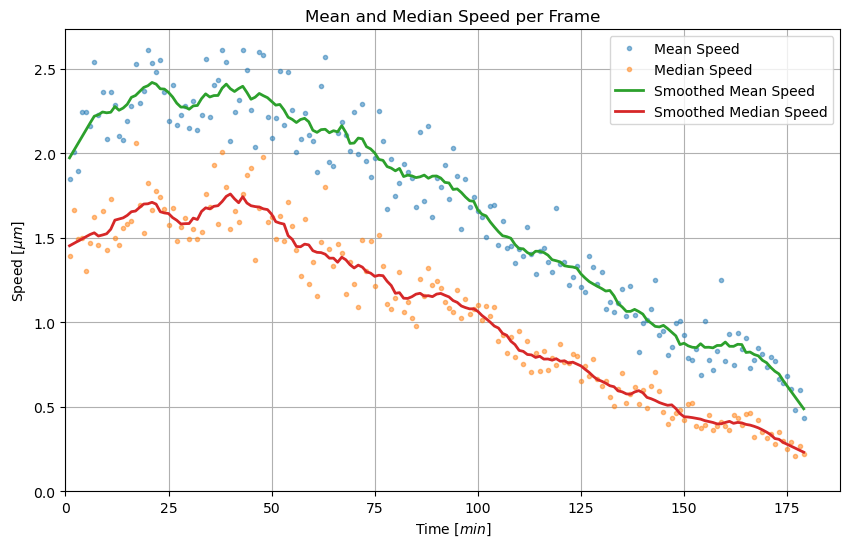

: 

: 

: 

In [ ]:
frames = Frame_stats['POSITION_T'][1:-1]
mean_speed = Frame_stats['SPEED_MEAN'][1:-1]
median_speed = Frame_stats['SPEED_MEDIAN'][1:-1]

# Apply Savitzky-Golay filter for smoothing
mean_speed_smooth = savgol_filter(mean_speed, window_length=11, polyorder=1)
median_speed_smooth = savgol_filter(median_speed, window_length=11, polyorder=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frames, mean_speed, '.', label='Mean Speed', alpha=0.5)
plt.plot(frames, median_speed, '.', label='Median Speed', alpha=0.5)
plt.plot(frames, mean_speed_smooth, '-', label='Smoothed Mean Speed', linewidth=2)
plt.plot(frames, median_speed_smooth, '-', label='Smoothed Median Speed', linewidth=2)

# Set x-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.xlabel(r'Time $\it{[min]}$')
plt.ylabel(r'Speed $\it{[μm]}$')
plt.title('Mean and Median Speed per Frame')
plt.legend()
plt.grid(True)
plt.show()

---


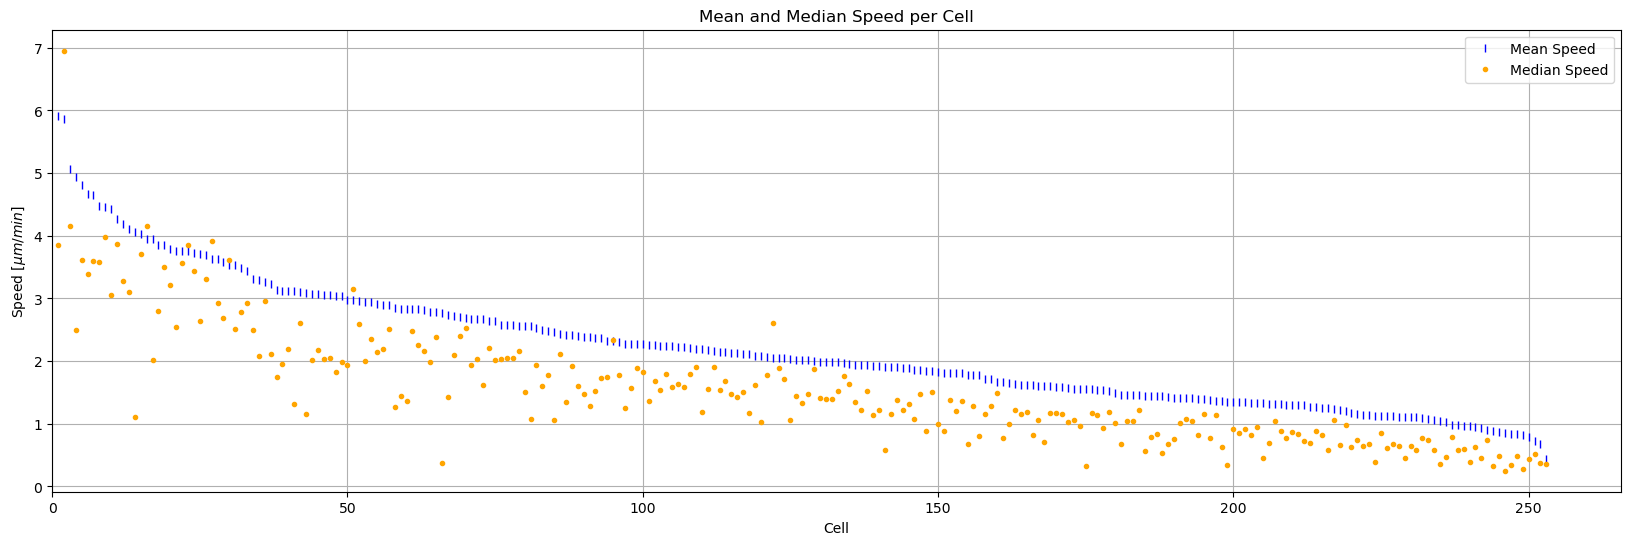

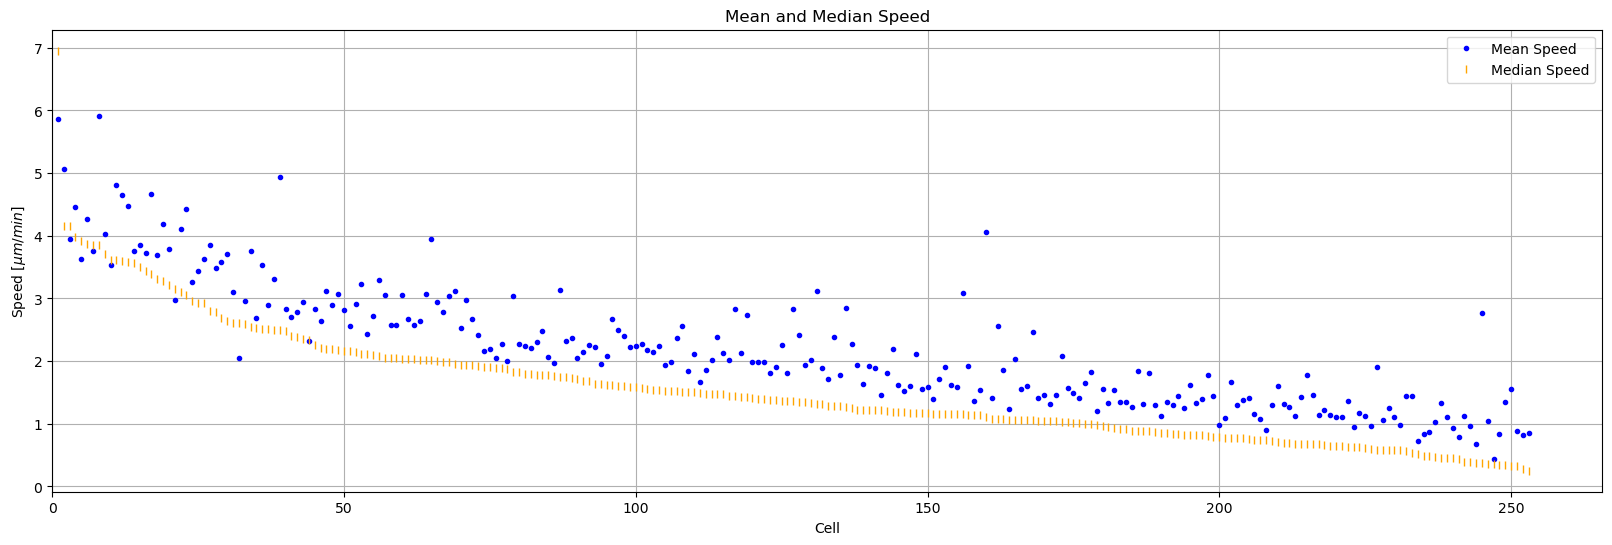

: 

: 

: 

In [ ]:
# Sort the DataFrame by 'TRACK_LENGTH' in ascending order
df_sorted_a = Track_stats.sort_values(by='SPEED_MEAN', ascending=False)
df_sorted_b = Track_stats.sort_values(by='SPEED_MEDIAN', ascending=False)

# Create new artificial IDs for sorting purposes (1 for lowest distance, N for highest)
df_sorted_a["Artificial_ID"] = range(1, len(df_sorted_a) + 1)
df_sorted_b["Artificial_ID"] = range(1, len(df_sorted_b) + 1)

# defining variables
cell_id_a = df_sorted_a["Artificial_ID"]
mean_speed_a = df_sorted_a['SPEED_MEAN']
median_speed_a = df_sorted_a['SPEED_MEDIAN']

cell_id_b = df_sorted_b["Artificial_ID"]
mean_speed_b = df_sorted_b['SPEED_MEAN']
median_speed_b = df_sorted_b['SPEED_MEDIAN']

# mean_speed_smooth = savgol_filter(mean_speed_a, window_length=11, polyorder=1)
# median_speed_smooth = savgol_filter(median_speed_b, window_length=11, polyorder=1)



x_span = PlotParams.x_span(Track_stats4_df, 0.08)

# Plotting no. 1
plt.figure(figsize=(x_span, 6))
plt.plot(cell_id_a, mean_speed_a, '|', label='Mean Speed', color='blue')
plt.plot(cell_id_a, median_speed_a, '.', label='Median Speed', color='orange')
# plt.plot(cell_id_a, mean_speed_smooth, '-', label='Mean Speed', linewidth=2, color='blue', zorder=1)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel('Cell')
plt.ylabel(r'Speed $\it{[μm/min]}$')
plt.title('Mean and Median Speed per Cell')
plt.legend()
plt.grid(True)
plt.show()


# Plotting no. 2
plt.figure(figsize=(20, 6))
plt.plot(cell_id_b, mean_speed_b, '.', label='Mean Speed', color='blue')
plt.plot(cell_id_b, median_speed_b, '|', label='Median Speed', color='orange')
# plt.plot(cell_id_b, median_speed_smooth, '-', label='Median Speed', linewidth=2, color='orange', zorder=1)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel('Cell')
plt.ylabel(r'Speed $\it{[μm/min]}$')
plt.title('Mean and Median Speed')
plt.legend()
plt.grid(True)
plt.show()

---
### Plotting the direction of migration &#x1F3D7;
&#x1F6A7; *under construction* &#x1F6A7; 

: 

: 

: 

<>:94: SyntaxWarning: invalid escape sequence '\i'
<>:94: SyntaxWarning: invalid escape sequence '\i'
C:\Users\modri\AppData\Local\Temp\ipykernel_13740\3041876227.py:94: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)


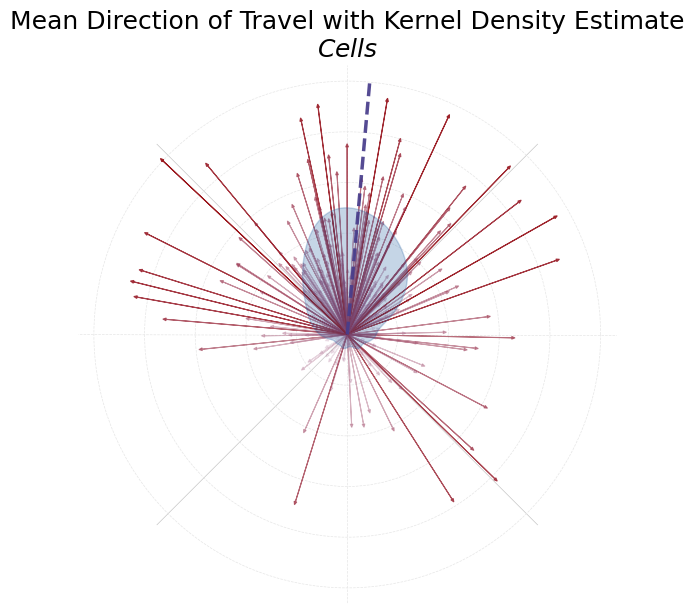

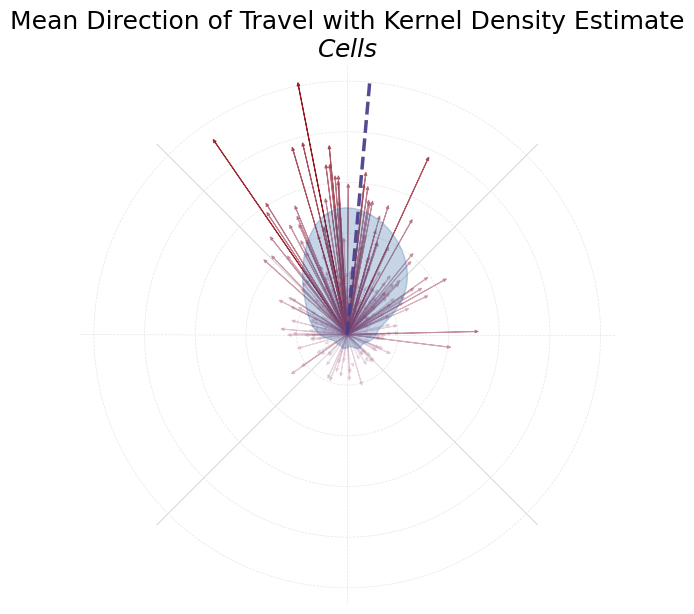

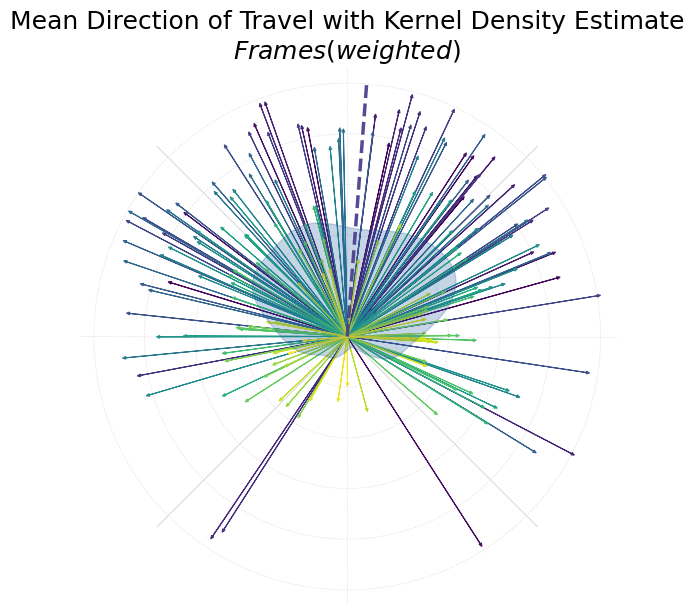

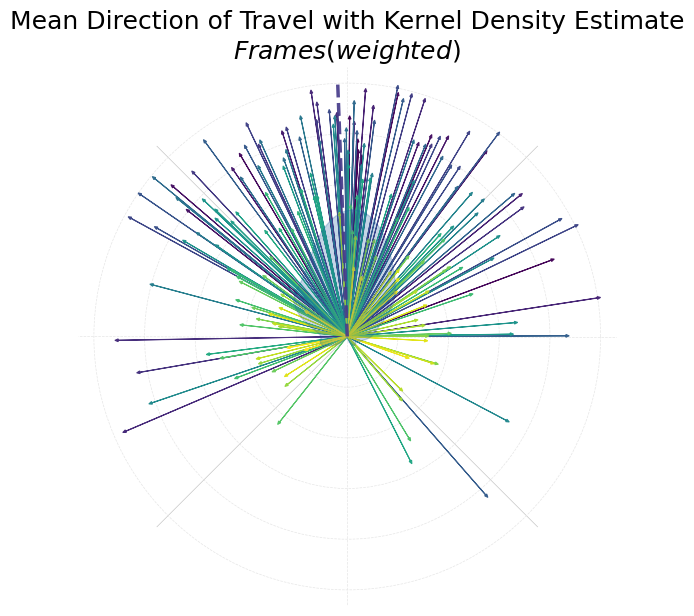

: 

: 

: 

In [ ]:
cmap_cells = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"]) #303030
cmap_frames = plt.get_cmap('viridis')

def migration_directions_with_kde_plus_mean(df, metric, subject, scaling_metric, cmap_normalization_metric, cmap, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    df_mean_direction = df[metric]

    # Prepare for KDE plot
    x_kde = np.cos(df_mean_direction)
    y_kde = np.sin(df_mean_direction)
    kde = gaussian_kde([x_kde, y_kde])

    # Define the grid for evaluation
    theta_kde = np.linspace(0, 2 * np.pi, 360)
    x_grid = np.cos(theta_kde)
    y_grid = np.sin(theta_kde)

    # Evaluate the KDE on the grid and normalize
    z_kde = kde.evaluate([x_grid, y_grid])
    z_kde = z_kde / z_kde.max() * 0.5  # Normalize to fit within the radial limit

    # Calculate the mean direction
    mean_direction = np.arctan2(np.mean(y_kde), np.mean(x_kde))

    # Start plotting
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'polar': True})

    # Plot KDE
    ax.plot(theta_kde, z_kde, label='Circular KDE', color='None', zorder=5)
    ax.fill(theta_kde, z_kde, alpha=0.25, color='#1b5a9e', zorder=5)

    # Directional Arrows
    scaling_max = df[scaling_metric].max()

    # Normalization of the color map
    if cmap_normalization_metric == None:
        norm = mcolors.Normalize(vmin=0, vmax=1)
    else:
        normalization_min = df[cmap_normalization_metric].min()
        normalization_max = df[cmap_normalization_metric].max()
        norm = mcolors.Normalize(vmin=normalization_min, vmax=normalization_max)

    # Row itteration
    for _, row in df.iterrows():
        scaling_metrics = row[scaling_metric]
        mean_direction_rad = row[metric]
        arrow_length = scaling_metrics / scaling_max

        if cmap_normalization_metric == None:
            color = cmap(norm(arrow_length))
        else:
            color = cmap(norm(row[cmap_normalization_metric]))

        if arrow_length == 0:
            continue  # Skip if the arrow length is zero

        # Dynamically adjust the head size based on arrow_length
        scaling_factor = 1 / arrow_length if arrow_length != 0 else 1
        head_width = 0.011 * scaling_factor
        head_length = 0.013

        ax.arrow(mean_direction_rad, 0, 0, arrow_length, color=color, linewidth=0.75, 
                head_width=head_width, head_length=head_length, zorder=4)

    # Plot the dashed line in the mean direction
    ax.plot([mean_direction, mean_direction], [0, 1], linestyle='--', color='darkslateblue', alpha=0.93, linewidth=2.5, zorder=6)

    # Hide the polar plot frame (spines) but keep the grid visible
    ax.spines['polar'].set_visible(False)
    # Customize grid lines (if needed)
    ax.grid(True, 'major', color='#C6C6C6', linestyle='-', linewidth=0.5, zorder=0)

    # Access and customize the radial grid lines
    radial_lines = ax.get_xgridlines()
    for i, line in enumerate(radial_lines):
        if i % 2 == 0:  # Customize every other radial grid line
            line.set_linestyle('--')
            line.set_color('#E6E6E6')
            line.set_linewidth(0.5)

    radial_lines = ax.get_ygridlines()
    for i, line in enumerate(radial_lines):
        line.set_linestyle('--')
        line.set_color('#E6E6E6')
        line.set_linewidth(0.5)

    # Customize the appearance of the polar plot
    ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)
    ax.set_yticklabels([])  # Remove radial labels
    ax.set_xticklabels([])  # Remove angular labels

    # Save the plot
    plt.savefig(op.join(save_path, f'02c_Plot_directions_of_travel_with_mean_and_kernel_density_estimate_{subject}_{scaling_metric}{threshold}.png'), dpi=500)
    # plt.show()
migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'CONFINEMENT_RATIO', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'NET_DISTANCE', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_confinement', 'Cells (weighted)', 'CONFINEMENT_RATIO', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_confinement', 'Cells (weighted)', 'NET_DISTANCE', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD_weight_net_dis', 'Cells (weighted)', 'CONFINEMENT_RATIO', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_net_dis', 'Cells (weighted)', 'NET_DISTANCE', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Frame_stats, 'MEAN_DIRECTION_RAD', 'Frames (weighted)', 'MEAN_DISTANCE', 'POSITION_T', cmap_frames, None)
migration_directions_with_kde_plus_mean(Frame_stats, 'MEAN_DIRECTION_RAD_weight_mean_dis', 'Frames (weighted)', 'MEAN_DISTANCE', 'POSITION_T', cmap_frames, None) 

In [ ]:
def donut(df, ax, outer_radius, inner_radius, kde_bw):
    # Extend the data circularly to account for wrap-around at 0 and 2*pi
    extended_data = np.concatenate([df - 2 * np.pi, df, df + 2 * np.pi])

    # Create a grid of theta values (angles)
    theta_grid = np.linspace(0, 2 * np.pi, 360)  # 360 points over full circle
    
    # Create a grid of radii
    r_grid = np.linspace(inner_radius, outer_radius, 100)  # Radius from inner to outer edge
    
    # Compute KDE values for the extended data
    kde = gaussian_kde(extended_data, bw_method=kde_bw)
    kde_values = kde.evaluate(theta_grid)  # Evaluate KDE on the regular theta grid
    
    # Repeat KDE values across radii to create the heatmap data
    kde_values = np.tile(kde_values, (r_grid.size, 1))
    
    # Normalize KDE values for consistent color mapping
    norm = Normalize(vmin=kde_values.min(), vmax=kde_values.max())
    
    # Create the meshgrid for the polar plot
    theta_mesh, r_mesh = np.meshgrid(theta_grid, r_grid)
    
    # Remove polar grid lines and labels
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines['polar'].set_visible(False)  # Hide the outer frame

    return theta_mesh, r_mesh, kde_values, norm

: 

: 

: 

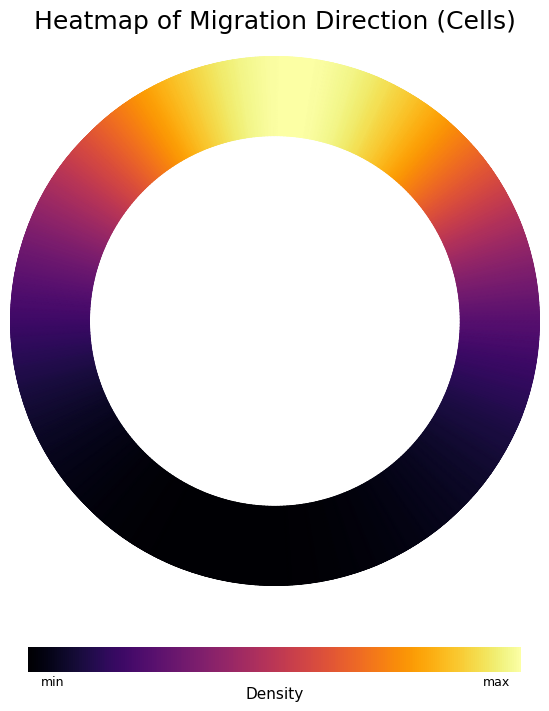

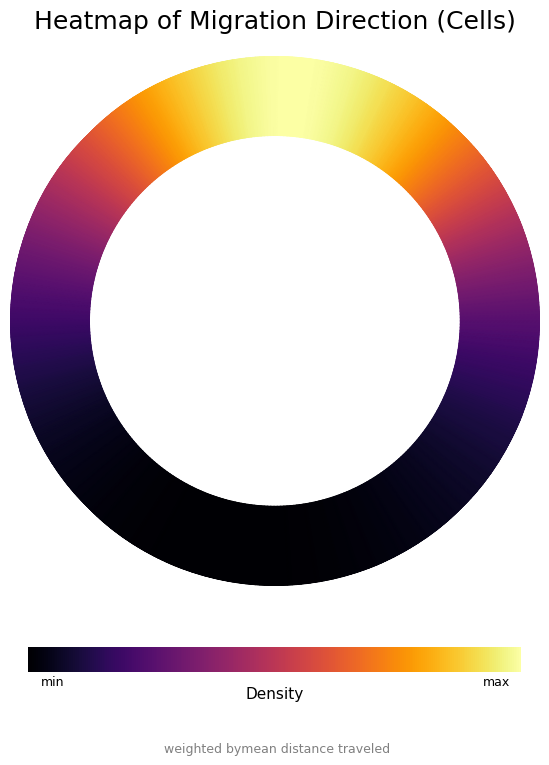

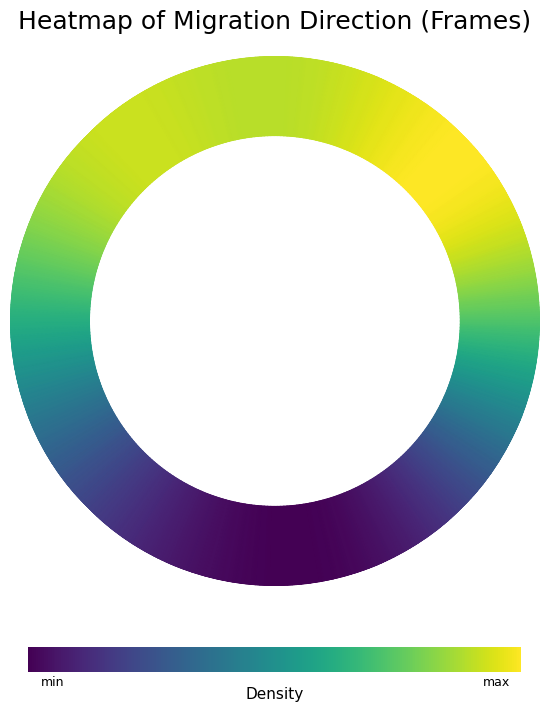

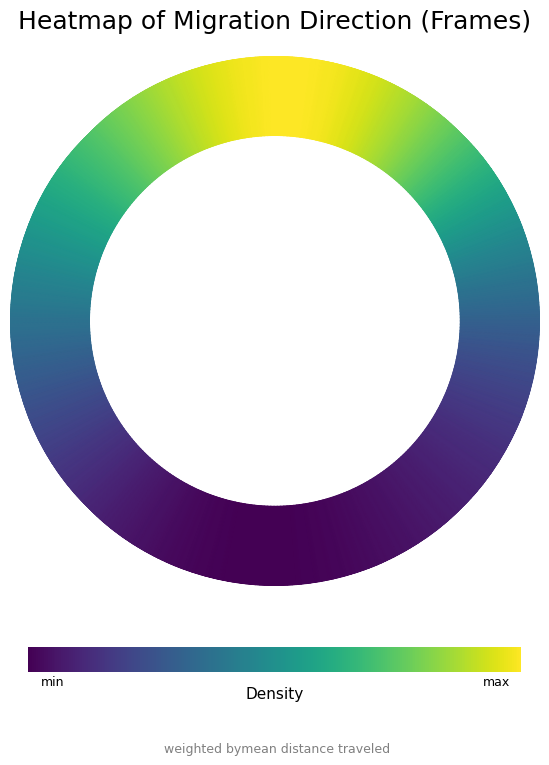

: 

: 

: 

In [ ]:

def df_gaussian_donut(df, metric, subject, heatmap, weight, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    diameter=2
    width_ratio=0.3
    kde_bw=0.1

    df=df[metric]

    # Calculate radius and width from the diameter
    outer_radius = diameter / 2
    width = width_ratio * outer_radius
    inner_radius = outer_radius - width
    
    theta_mesh, r_mesh, kde_values, norm = donut(df, ax, outer_radius, inner_radius, kde_bw)
    
    # Set title and figure text
    ax.set_title(f'Heatmap of Migration Direction ({subject})', pad=20, ha='center', fontsize=title_size)
    
    # Add a colorbar
    cbar = plt.colorbar(ax.pcolormesh(theta_mesh, r_mesh, kde_values, shading='gouraud', cmap=heatmap, norm=norm), ax=ax, fraction=0.04, orientation='horizontal', pad=0.1)
    cbar.set_ticks([])
    cbar.outline.set_visible(False)  # Remove outline
    
    # Add min and max labels below the colorbar
    cbar.ax.text(0.05, -0.4, 'min', va='center', ha='center', color='black', transform=cbar.ax.transAxes, fontsize=9)
    cbar.ax.text(0.95, -0.4, 'max', va='center', ha='center', color='black', transform=cbar.ax.transAxes, fontsize=9)

    # Add the density label below the min and max labels
    cbar.set_label('Density', labelpad=10, fontsize=label_size)
    
    if weight == None:
        plt.savefig(op.join(save_path, f'04a_Plot_donut_heatmap-migration_direction_{subject}{threshold}.png'), dpi=300)
    else:
        weight = 'weighted by' + weight
        plt.figtext(0.515, 0.01, f'{weight}', ha='center', color=figtext_color, fontsize=figtext_size)
        plt.savefig(op.join(save_path, f'04a_Plot_donut_heatmap-migration_direction_{subject}{weight}{threshold}.png'), dpi=300)

    # plt.show()
df_gaussian_donut(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', None, None)
df_gaussian_donut(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'mean distance traveled', None)
# df_gaussian_donut(Track_stats_thresholded_at_20th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_20th_percentile') # 20th
# df_gaussian_donut(Track_stats_thresholded_at_40th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_40th_percentile') # 40th
# df_gaussian_donut(Track_stats_thresholded_at_60th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_60th_percentile') # 60th
# df_gaussian_donut(Track_stats_thresholded_at_80th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_80th_percentile') # 80th
# df_gaussian_donut(Track_stats_thresholded_at_90th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_90th_percentile') # 90th
df_gaussian_donut(Frame_stats, 'MEAN_DIRECTION_RAD', 'Frames', 'viridis', None, None)
df_gaussian_donut(Frame_stats, 'MEAN_DIRECTION_RAD_weight_mean_dis', 'Frames', 'viridis', 'mean distance traveled', None)


---
# *To try* / *To do* List

<ul>
    <li><input type="checkbox"> Weight Mean direction of travel in Time_Stats also by the NET_DISTANCE, making the dataset contain two columns for the weighted mean direction; by confinement ratio as well as net distance </li>

</ul>
